# Ensemble Techniques - Predict the likelihood of a customer subscribing to Term Deposit

**Data Description:**

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed.

**Context:**

Leveraging customer information is paramount for most businesses. In the case of a bank, attributes of customers like the ones mentioned below can be crucial in strategizing a marketing campaign when launching a new product.

**Attribute Information:**

1. age (numeric)
2. job : type of job (categorical:admin.','bluecollar','entrepreneur','housemaid','management','retired','selfemployed','services','student','technician','unemployed','unknown')
3. marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4. education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5. default: has credit in default? (categorical: 'no','yes','unknown')
6. balance: average yearly balance, in euros (numeric)
7. housing: has housing loan? (categorical: 'no','yes','unknown')
8. loan: has personal loan? (categorical: 'no','yes','unknown')
9. contact: contact communication type categorical: 'cellular','telephone'
10. day: last contact day of the month (numeric 1 -31)
11. month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
12. duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
13. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
14. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
15. previous: number of contacts performed before this campaign and for this client (numeric)
16. poutcome: outcome of the previous marketing campaign (categorical:'failure','nonexistent','success')
17. target: has the client subscribed a term deposit? (binary: "yes","no")

**Objective:**
The classification goal is to predict if the client will subscribe (yes/no) a term deposit (variable y).

In [198]:
# Import necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler, LabelEncoder, normalize
from imblearn.over_sampling import SMOTE 

from sklearn import metrics
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifiers, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc

In [2]:
df1 = pd.read_csv('bank-full.csv')

In [3]:
df1.shape

(45211, 17)

Dataset has 45211 rows and 17 columns

In [4]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
age          45211 non-null int64
job          45211 non-null object
marital      45211 non-null object
education    45211 non-null object
default      45211 non-null object
balance      45211 non-null int64
housing      45211 non-null object
loan         45211 non-null object
contact      45211 non-null object
day          45211 non-null int64
month        45211 non-null object
duration     45211 non-null int64
campaign     45211 non-null int64
pdays        45211 non-null int64
previous     45211 non-null int64
poutcome     45211 non-null object
Target       45211 non-null object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


**Note:**
* Null values are **not** present in dataset. 
* Variables with object datatypes are present.

In [5]:
df1.isna().count()

age          45211
job          45211
marital      45211
education    45211
default      45211
balance      45211
housing      45211
loan         45211
contact      45211
day          45211
month        45211
duration     45211
campaign     45211
pdays        45211
previous     45211
poutcome     45211
Target       45211
dtype: int64

NaN values are **not** present

In [6]:
# change the object datatype to category

for i in df1.columns:
    if df1[i].dtype == 'object':
        df1[i] = pd.Categorical(df1[i])

In [7]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
age          45211 non-null int64
job          45211 non-null category
marital      45211 non-null category
education    45211 non-null category
default      45211 non-null category
balance      45211 non-null int64
housing      45211 non-null category
loan         45211 non-null category
contact      45211 non-null category
day          45211 non-null int64
month        45211 non-null category
duration     45211 non-null int64
campaign     45211 non-null int64
pdays        45211 non-null int64
previous     45211 non-null int64
poutcome     45211 non-null category
Target       45211 non-null category
dtypes: category(10), int64(7)
memory usage: 2.8 MB


* **Datatypes Object are replaced with category**

In [8]:
# check whether duplicates present in the data

dups = df1[df1.duplicated()]
dups

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,Target


**Duplicates are not found in dataset.**

In [9]:
df1.describe().T

,count,mean,std,min,25%,50%,75%,max
age,45211.0,40.936210,10.618762,18.0,33.0,39.0,48.0,95.0
balance,45211.0,1362.272058,3044.765829,-8019.0,72.0,448.0,1428.0,102127.0
day,45211.0,15.806419,8.322476,1.0,8.0,16.0,21.0,31.0
duration,45211.0,258.163080,257.527812,0.0,103.0,180.0,319.0,4918.0
campaign,45211.0,2.763841,3.098021,1.0,1.0,2.0,3.0,63.0
pdays,45211.0,40.197828,100.128746,-1.0,-1.0,-1.0,-1.0,871.0
previous,45211.0,0.580323,2.303441,0.0,0.0,0.0,0.0,275.0


* Data looks reasonable.
* Columns **balance, duration, pdays and previous have right skewed distribution since mean is higher than median.** 
* **Median is -1 for column pdays** since more than half of the values are zero 

In [10]:
print('Skewness of Age        : ', df1["age"].skew())
print('Skewness of Balance    : ', df1["balance"].skew())
print('Skewness of Day        : ', df1["day"].skew())
print('Skewness of Duration   : ', df1["duration"].skew())
print('Skewness of Campaign   : ', df1["campaign"].skew())
print('Skewness of Pdays      : ', df1["pdays"].skew())
print('Skewness of Previous   : ', df1["previous"].skew())

Skewness of Age        :  0.6848179257252598
Skewness of Balance    :  8.360308326166326
Skewness of Day        :  0.09307901402122411
Skewness of Duration   :  3.144318099423456
Skewness of Campaign   :  4.898650166179674
Skewness of Pdays      :  2.6157154736563477
Skewness of Previous   :  41.84645447266292


* As seen above, balance, duration, campaign, pdays and previous have right skewed distribution.
* Age and day are little left skewed

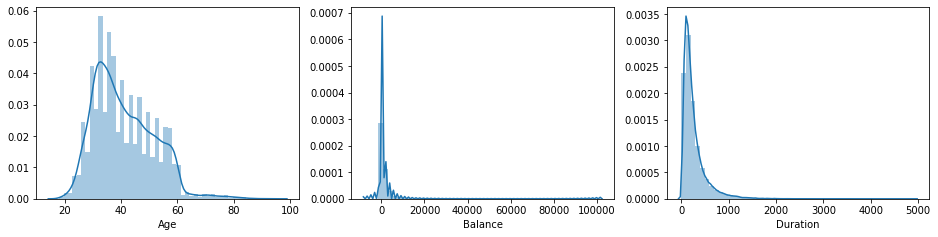

In [11]:
# Hist plots to find the distribution of continuous variables

plt.figure(figsize = (16,12))
plt.subplot(3,3,1)
sns.distplot(df1['age'])
plt.xlabel("Age")
plt.subplot(3,3,2)
sns.distplot(df1['balance'])
plt.xlabel("Balance")
plt.subplot(3,3,3)
sns.distplot(df1['duration'])
plt.xlabel("Duration")
plt.show()

* Data looks like normal distribution for Age, Balance and Duration, however, Balance and Duration are heavily right skewed. 

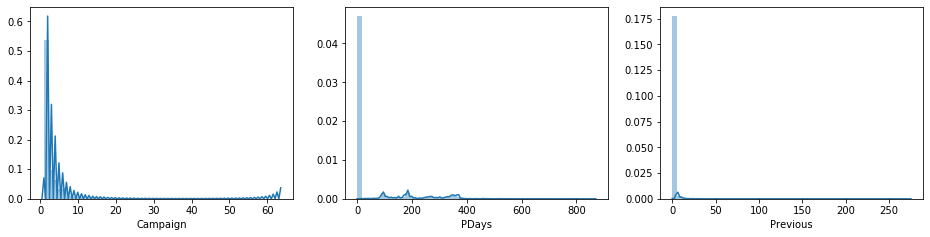

In [12]:
plt.figure(figsize = (16,12))
plt.subplot(3,3,1)
sns.distplot(df1['campaign'])
plt.xlabel("Campaign")
plt.subplot(3,3,2)
sns.distplot(df1['pdays'])
plt.xlabel("PDays")
plt.subplot(3,3,3)
sns.distplot(df1['previous'])
plt.xlabel("Previous")
plt.show()

* Campaign have right skewed distribution.
* Pdays and Previous does not follow any distribution

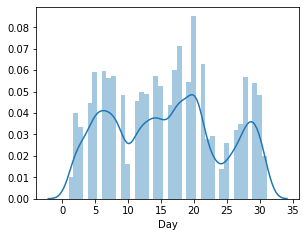

In [13]:
plt.figure(figsize = (16,12))
plt.subplot(3,3,1)
sns.distplot(df1['day'])
plt.xlabel("Day")
plt.show()

* Day shows multiple peaks, which indicates more data available for multiple days. 

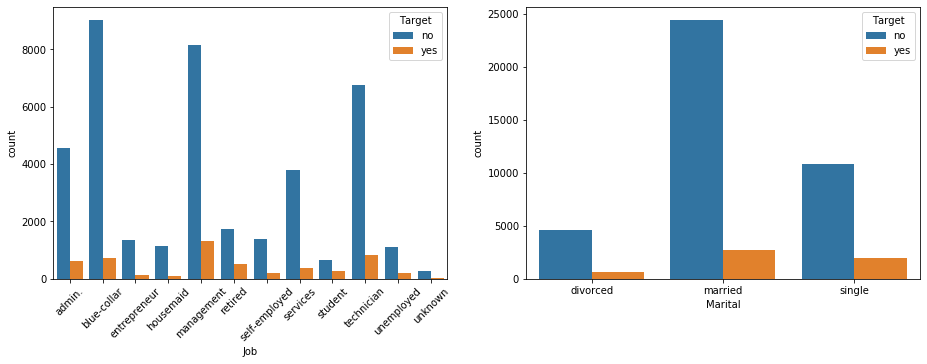

In [14]:
#Count plot to check the distribution of categorical variables
plt.figure(figsize=(24,17))
plt.subplot(3,3,1)
ch1 = sns.countplot(df1.job,hue=df1.Target)
ch1.set_xticklabels(ch1.get_xticklabels(), rotation=45)
plt.xlabel("Job")

plt.subplot(3,3,2)
sns.countplot(df1.marital,hue=df1.Target)
plt.xlabel("Marital")
plt.show()

**Observations -**
* **Data shows people working in Management has the highest Term deposit subsciption.**
* **People working as Technician, blue-collar, retired and admin have higher Term deposit subscriptions than enterpreneur, housemaid, self-employed, student, unemployed and unknown.**
* **People with marital status Married and Single have higher Term deposit subscriptions than Divorced.** 

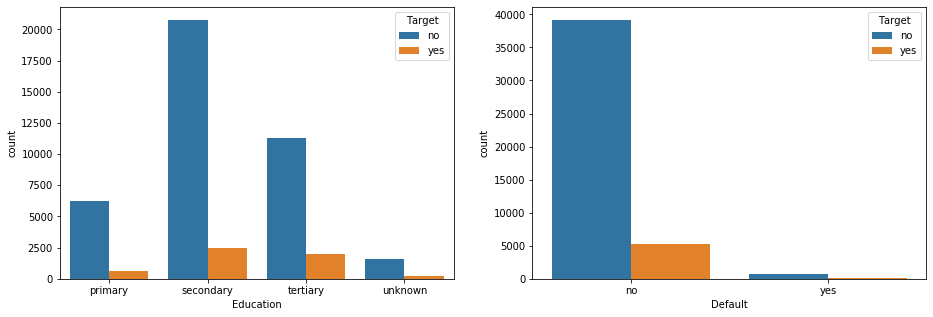

In [15]:
plt.figure(figsize=(24,17))
plt.subplot(3,3,1)
sns.countplot(df1.education,hue=df1.Target)
plt.xlabel("Education")

plt.subplot(3,3,2)
sns.countplot(df1.default,hue=df1.Target)
plt.xlabel("Default")
plt.show()

**Observations -**
* **People with Education Secondary and Tertiary have higher Term deposit subscriptions than Primary and unknown.**
* **People with no credit in default have higher Term deposit subscriptions than having credit.**

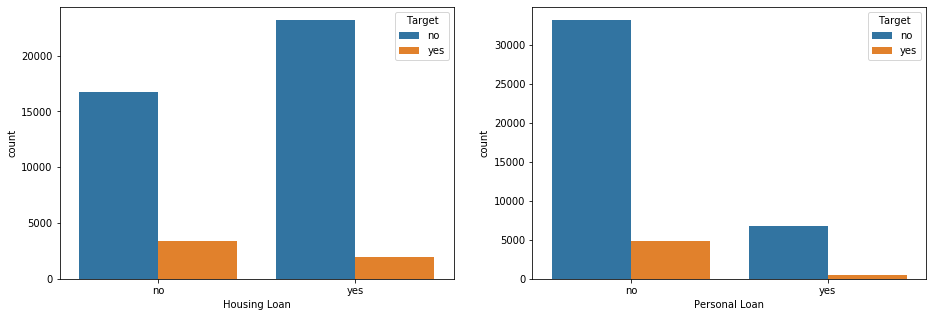

In [16]:
plt.figure(figsize=(24,17))
plt.subplot(3,3,1)
sns.countplot(df1.housing,hue=df1.Target)
plt.xlabel("Housing Loan")

plt.subplot(3,3,2)
ch1 = sns.countplot(df1.loan,hue=df1.Target)
plt.xlabel("Personal Loan")
plt.show()

**Observations -**
* **People with Education Secondary and Tertiary have higher Term deposit subscriptions than Primary and unknown.**
* **People with no credit in default have higher Term deposit subscriptions than having credit.**

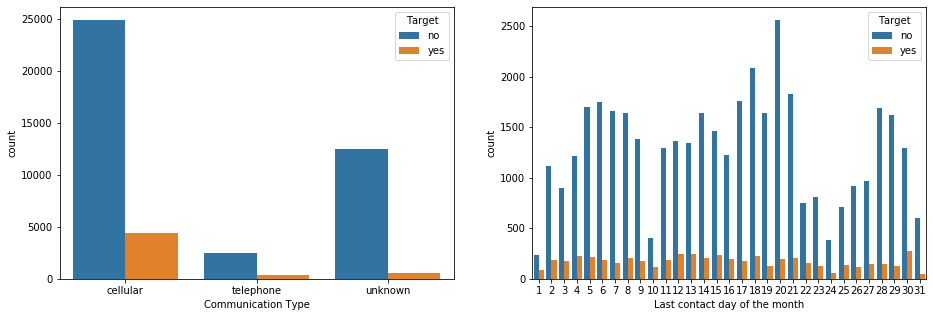

In [17]:
plt.figure(figsize=(24,17))
plt.subplot(3,3,1)
sns.countplot(df1.contact,hue=df1.Target)
plt.xlabel("Communication Type")

plt.subplot(3,3,2)
ch1 = sns.countplot(df1.day,hue=df1.Target)
plt.xlabel("Last contact day of the month")
plt.show()

**Observations -**
* **It looks like people who were contacted though cell phone have higher Term deposit subscriptions than Telephone and unknown. However, this could be due to most of the people were contacted through cell phone.**
* **Regardless of when people contacted in a month, there has been good number of Term deposit subsciptions throughout the month.**

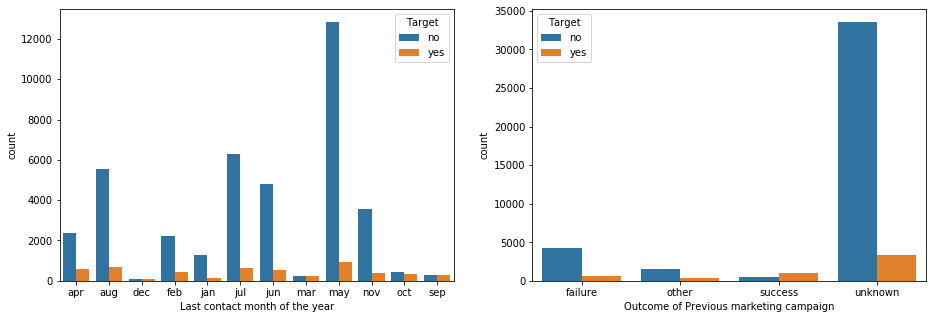

In [18]:
plt.figure(figsize=(24,17))
plt.subplot(3,3,1)
sns.countplot(df1.month,hue=df1.Target)
plt.xlabel("Last contact month of the year")

plt.subplot(3,3,2)
ch1 = sns.countplot(df1.poutcome,hue=df1.Target)
plt.xlabel("Outcome of Previous marketing campaign")
plt.show()

* More data are available for the months of May, Jun, Jul, Aug and Nov
* Couldnt infer much from "Last contact month of the year" and "Outcome of previous marketing campaign" fields.  

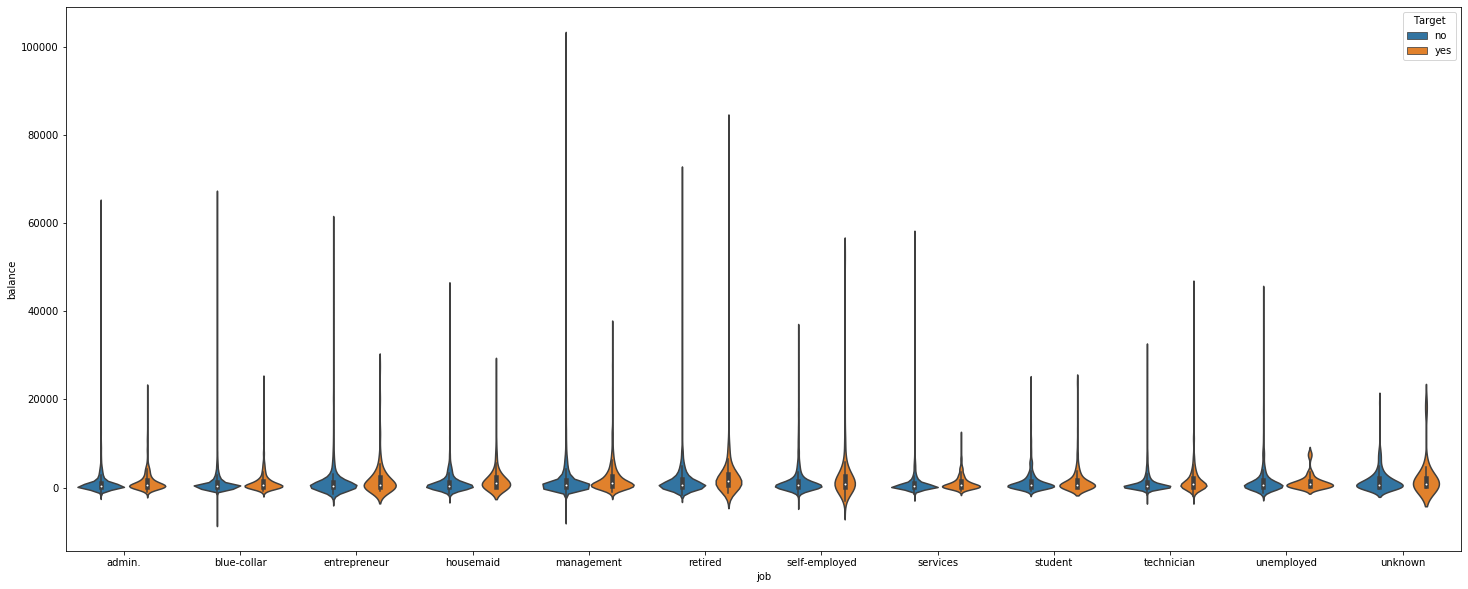

In [19]:
# violin plot to check the 
plt.figure(figsize = (25,10))
sns.violinplot(x= df1.job, y = df1.balance, hue = df1.Target)

**Interesting observation** - The assumption is people with high balance subscribe to Term deposits. But, the data shows the opposite. People who have high balance have not subscribed to Term deposits except people who are self-employed, Students and technicians. And the distribution is almost same between Target Yes and No for all the variables. 

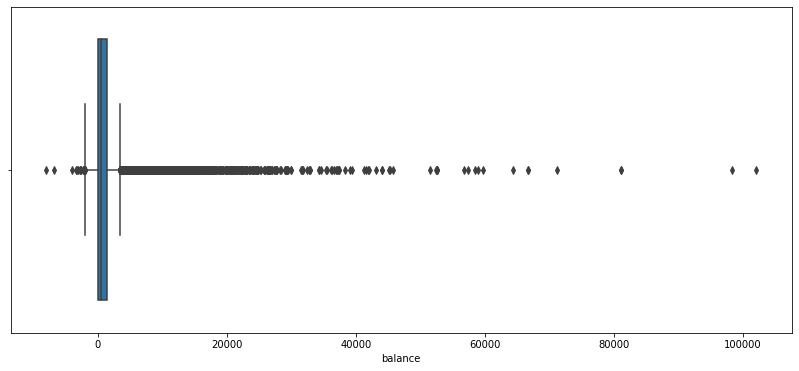

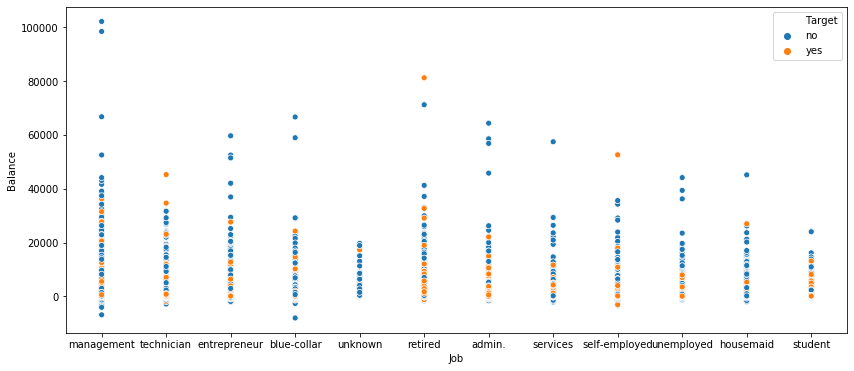

In [20]:
plt.figure(figsize=(14,6))
sns.boxplot(df1.balance)
plt.show()

plt.figure(figsize=(14,6))
ch1 = sns.scatterplot(x= df1.job, y = df1.balance, hue = df1.Target)
plt.xlabel("Job")
plt.ylabel("Balance")
plt.show()

**Outliers are present on both ends for Balance.**

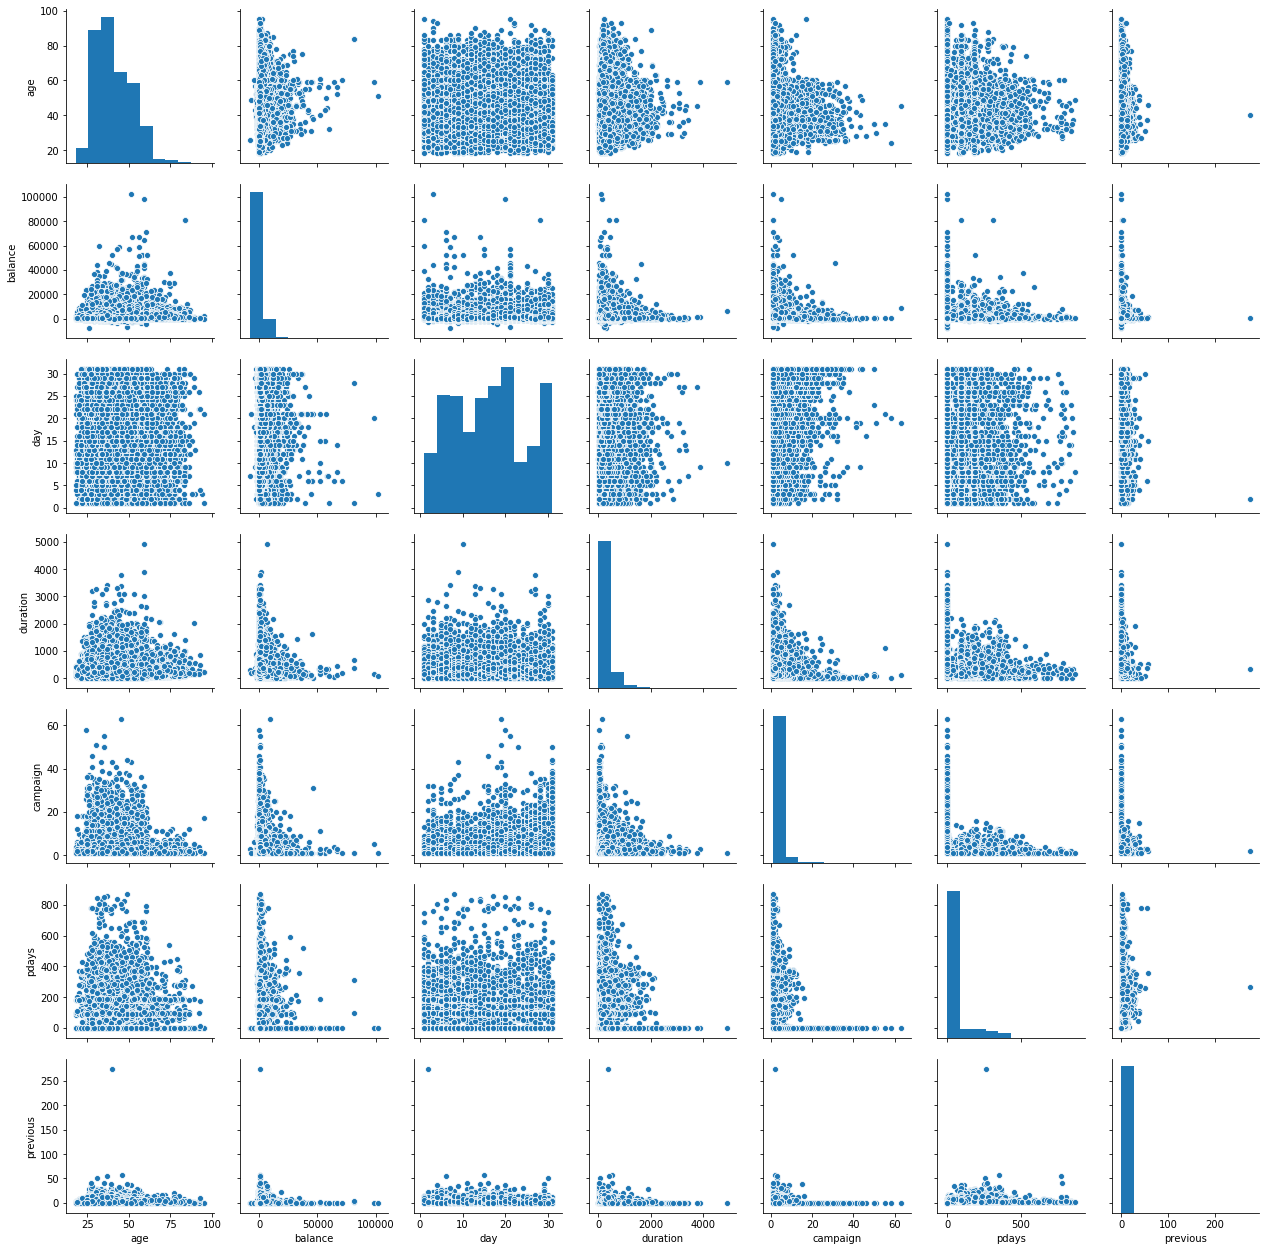

In [21]:
sns.pairplot(df1)

**Pair plot proves no relationship between any variables.**

(7.0, 0.0)

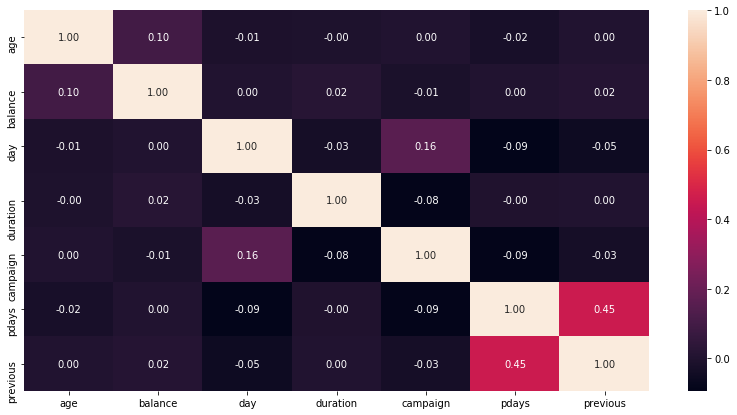

In [22]:
corr1 = df1.corr()
plt.figure(figsize=(14,7))
hm1 = sns.heatmap(corr1,annot=True, fmt = '.2f')
bottom, top = hm1.get_ylim()
hm1.set_ylim(bottom + 0.5, top - 0.5)

**No significant correlation between any variables.** 

### Data Preparation - Convert categorical to numerical values

In [23]:
lbl = LabelEncoder()
df1["Target"]  = lbl.fit_transform(df1["Target"])
df1["default"] = lbl.fit_transform(df1["default"])
df1["housing"] = lbl.fit_transform(df1["housing"])
df1["loan"]    = lbl.fit_transform(df1["loan"])

df1['education'] = df1['education'].map({'primary': 1, 'secondary': 2, 'tertiary': 3, 'unknown': -1})
df1['job'] = df1['job'].map({'admin.': 1, 'blue-collar': 2, 'entrepreneur': 3, 'housemaid': 4, 'management': 5, 'retired': 6,
                            'self-employed': 7, 'services': 8, 'student': 9, 'technician': 10, 'unemployed': 11, 
                            'unknown': -1})
df1['contact'] = df1['contact'].map({'cellular': 1, 'telephone': 2, 'unknown': -1})
df1['month'] = df1['month'].map({'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6, 'jul': 7, 'aug': 8, 'sep': 9,
                                'oct': 10, 'nov': 11, 'dec': 12})
df1['poutcome'] = df1['poutcome'].map({'failure': 1, 'other': 2, 'success': 3, 'unknown': -1})

dCols=["marital"]
df1 = pd.get_dummies(df1, columns = dCols)

In [24]:
df1.head(10)

,age,job,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,Target,marital_divorced,marital_married,marital_single
0,58,5,3,0,2143,1,0,-1,5,5,261,1,-1,0,-1,0,0,1,0
1,44,10,2,0,29,1,0,-1,5,5,151,1,-1,0,-1,0,0,0,1
2,33,3,2,0,2,1,1,-1,5,5,76,1,-1,0,-1,0,0,1,0
3,47,2,-1,0,1506,1,0,-1,5,5,92,1,-1,0,-1,0,0,1,0
4,33,-1,-1,0,1,0,0,-1,5,5,198,1,-1,0,-1,0,0,0,1
5,35,5,3,0,231,1,0,-1,5,5,139,1,-1,0,-1,0,0,1,0
6,28,5,3,0,447,1,1,-1,5,5,217,1,-1,0,-1,0,0,0,1
7,42,3,3,1,2,1,0,-1,5,5,380,1,-1,0,-1,0,1,0,0
8,58,6,1,0,121,1,0,-1,5,5,50,1,-1,0,-1,0,0,1,0
9,43,10,2,0,593,1,0,-1,5,5,55,1,-1,0,-1,0,0,0,1


### Target column Distribution

In [25]:
df1['Target'].value_counts()

0    39922
1     5289
Name: Target, dtype: int64

In [26]:
df1['Target'].value_counts(normalize=True)

0    0.883015
1    0.116985
Name: Target, dtype: float64

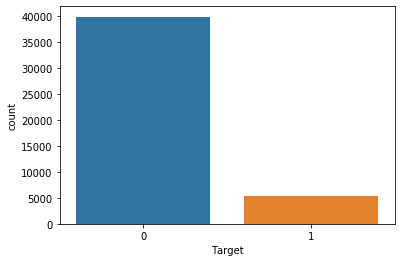

In [27]:
sns.countplot(df1.Target)

#### This is a Class Imbalance Problem. 88% of rows belong to people who have not subscribed to Term Deposit. 

### Check the influence of Duration column

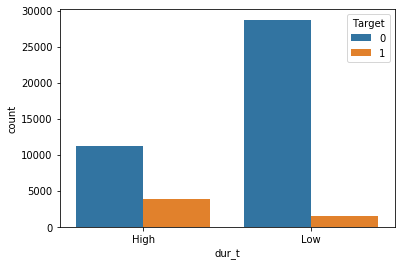

In [28]:
# check the impact of duration on Target
z = df1["duration"].mean()

# created a new column dur_t which will have value "Low" for duration value less than its mean, and "High" for values greater
#  than mean. This is to find the influence of higher call duration on Target variable. 
df1["dur_t"] = np.where(df1["duration"] < z, "Low", "High") 
sns.countplot(df1.dur_t, hue=df1.Target)

**Approx 40% of people who had a longer call duration subscribed for Deposit.**

In [29]:
df1.drop("dur_t", axis=1,inplace = True)
df1.head()

,age,job,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,Target,marital_divorced,marital_married,marital_single
0,58,5,3,0,2143,1,0,-1,5,5,261,1,-1,0,-1,0,0,1,0
1,44,10,2,0,29,1,0,-1,5,5,151,1,-1,0,-1,0,0,0,1
2,33,3,2,0,2,1,1,-1,5,5,76,1,-1,0,-1,0,0,1,0
3,47,2,-1,0,1506,1,0,-1,5,5,92,1,-1,0,-1,0,0,1,0
4,33,-1,-1,0,1,0,0,-1,5,5,198,1,-1,0,-1,0,0,0,1


In [30]:
# change the datatype to int64 since numerical values are present in the dataset
df1['job'] = df1['job'].astype('int64') 
df1['education'] = df1['education'].astype('int64') 
df1['contact'] = df1['contact'].astype('int64') 
df1['month'] = df1['month'].astype('int64') 
df1['poutcome'] = df1['poutcome'].astype('int64') 

In [31]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 19 columns):
age                 45211 non-null int64
job                 45211 non-null int64
education           45211 non-null int64
default             45211 non-null int32
balance             45211 non-null int64
housing             45211 non-null int32
loan                45211 non-null int32
contact             45211 non-null int64
day                 45211 non-null int64
month               45211 non-null int64
duration            45211 non-null int64
campaign            45211 non-null int64
pdays               45211 non-null int64
previous            45211 non-null int64
poutcome            45211 non-null int64
Target              45211 non-null int32
marital_divorced    45211 non-null uint8
marital_married     45211 non-null uint8
marital_single      45211 non-null uint8
dtypes: int32(4), int64(12), uint8(3)
memory usage: 5.0 MB


#### Build Decision Tree and Logistic Regression to check the influence of Duration

In [32]:
x1 = df1.drop("Target", axis = 1) # Duration is not dropped
y1 = df1["Target"]

xtrain1, xtest1, ytrain1, ytest1 = train_test_split(x1, y1, test_size = 0.30, random_state=1)

In [33]:
print("Training set contains {0:0.1f}% of data" .format((len(xtrain1)/len(df1))*100))
print("Test set contains {0:0.1f}% of data" .format((len(xtest1)/len(df1))*100))

Training set contains 70.0% of data
Test set contains 30.0% of data


In [34]:
DT1 = DecisionTreeClassifier(criterion = 'gini', random_state=1)
DT1.fit(xtrain1,ytrain1)
print("Decision Tree Training score : ", DT1.score(xtrain1,ytrain1))
print("Decision Tree Test score     : ", DT1.score(xtest1,ytest1))

Decision Tree Training score :  1.0
Decision Tree Test score     :  0.8692126216455323


In [35]:
print (pd.DataFrame(DT1.feature_importances_, columns = ["Feature Importances"], index = xtrain1.columns))

                  Feature Importances
age                          0.095988
job                          0.040448
education                    0.029313
default                      0.001816
balance                      0.118431
housing                      0.018915
loan                         0.011135
contact                      0.021332
day                          0.098108
month                        0.070466
duration                     0.287711
campaign                     0.039635
pdays                        0.040578
previous                     0.012497
poutcome                     0.092938
marital_divorced             0.005691
marital_married              0.007865
marital_single               0.007134


**NOTE: Duration has the highest weightage/importance in predicting the Target variable**

In [36]:
LR1 = LogisticRegression(solver='liblinear')
LR1.fit(xtrain1,ytrain1)
print("Logistic regression Training score :", LR1.score(xtrain1,ytrain1))
print("Logistic regression Test score     :", LR1.score(xtest1,ytest1))

Logistic regression Training score : 0.8982841975542706
Logistic regression Test score     : 0.8980389265703332


Text(0.5, 1, 'Decision Tree before SMOTE')

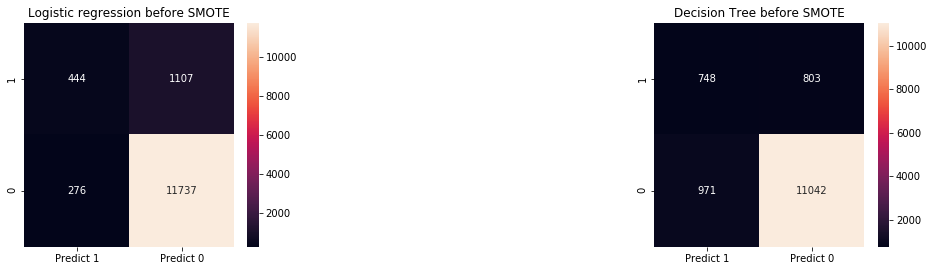

In [37]:
# Confustion Matrix
predz = LR1.predict(xtest1)
cmz=metrics.confusion_matrix(ytest1, predz, labels=[1, 0])
df_cma = pd.DataFrame(cmz, index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])

predy = DT1.predict(xtest1)
cmy=metrics.confusion_matrix(ytest1, predy, labels=[1, 0])
df_cmb = pd.DataFrame(cmy, index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])

plt.figure(figsize = (16,14))
plt.subplot(3,3,1)
hm2 = sns.heatmap(df_cma, annot=True, fmt='g')
bottom, top = hm2.get_ylim()
hm2.set_ylim (bottom +0.5, top - 0.5)
plt.title("Logistic regression before SMOTE")

plt.subplot(3,3,3)
hm3 = sns.heatmap(df_cmb, annot=True, fmt='g')
bottom, top = hm3.get_ylim()
hm3.set_ylim (bottom +0.5, top - 0.5)
plt.title("Decision Tree before SMOTE")

**These confusion matrices are built for reference purpose i.e. to compare how the model perform before/after SMOTE. These numbers will be referenced down the line.**

In [38]:
print("Classification Report For DT1")
print("")
pred1 = DT1.predict(xtest1)
DT_log1 = metrics.classification_report(ytest1, pred1, labels = [1,0])
print(DT_log1)
print("-----------------------------------------------------")
print("Classification Report For LR1")
print("")
pred2 = LR1.predict(xtest1)
LR_log = metrics.classification_report(ytest1, pred2, labels = [1,0])
print(LR_log)

Classification Report For DT1

              precision    recall  f1-score   support

           1       0.44      0.48      0.46      1551
           0       0.93      0.92      0.93     12013

    accuracy                           0.87     13564
   macro avg       0.68      0.70      0.69     13564
weighted avg       0.88      0.87      0.87     13564

-----------------------------------------------------
Classification Report For LR1

              precision    recall  f1-score   support

           1       0.62      0.29      0.39      1551
           0       0.91      0.98      0.94     12013

    accuracy                           0.90     13564
   macro avg       0.77      0.63      0.67     13564
weighted avg       0.88      0.90      0.88     13564



#### Note: 
* **Scores of Target "1" is low due to class imbalance problem.**


* **Synthetic rows to be created and used to build models for better prediction of people who subscribed to Term deposit.**

In [39]:
for idx, col_name in enumerate(xtrain1.columns):
    print("The coefficient for {} is {}".format(col_name, round(LR1.coef_[0][idx], 5)))

The coefficient for age is 0.00218
The coefficient for job is 0.00556
The coefficient for education is 0.09942
The coefficient for default is -0.29651
The coefficient for balance is 2e-05
The coefficient for housing is -0.88692
The coefficient for loan is -0.59854
The coefficient for contact is 0.44383
The coefficient for day is -0.00642
The coefficient for month is -0.0062
The coefficient for duration is 0.00413
The coefficient for campaign is -0.1132
The coefficient for pdays is -0.00255
The coefficient for previous is -0.0221
The coefficient for poutcome is 0.65852
The coefficient for marital_divorced is -0.71318
The coefficient for marital_married is -0.88357
The coefficient for marital_single is -0.49212


**Note: In Logistic Regression, Duration is not highly influencing the Target variable, but it has significant influence**

#### As the data suggests, Duration has high influence on Target variable. Therefore, Duration will be dropped from dataframe 

In [40]:
df1.drop("duration", axis=1,inplace = True)
df1.head()

,age,job,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,Target,marital_divorced,marital_married,marital_single
0,58,5,3,0,2143,1,0,-1,5,5,1,-1,0,-1,0,0,1,0
1,44,10,2,0,29,1,0,-1,5,5,1,-1,0,-1,0,0,0,1
2,33,3,2,0,2,1,1,-1,5,5,1,-1,0,-1,0,0,1,0
3,47,2,-1,0,1506,1,0,-1,5,5,1,-1,0,-1,0,0,1,0
4,33,-1,-1,0,1,0,0,-1,5,5,1,-1,0,-1,0,0,0,1


### To handle class imbalance problem, Add synthetic rows using SMOTE

In [41]:
x2 = df1.drop("Target", axis = 1)
y2 = df1["Target"]

In [42]:
# train and test datasets are prepared without duration

xtrain2, xtest2, ytrain2, ytest2 = train_test_split(x2, y2, test_size = 0.30, random_state=1)

In [43]:
# SMOTE has been applied only on Training sets

sm = SMOTE(random_state = 2)  
xtrain_sm, ytrain_sm = sm.fit_sample(xtrain2, ytrain2) 

In [44]:
print("Before SMOTE - xtrain shape : ", xtrain2.shape)
print("After SMOTE  - xtrain shape : ", xtrain_sm.shape)
print("")
print("Before SMOTE - ytrain shape : ", ytrain2.shape)
print("After  SMOTE - ytrain shape : ", ytrain_sm.shape)
print("")
print("Before SMOTE - ytrain distribution : ")
dfx = pd.DataFrame()
dfx['Target0'] = ytrain2
print( dfx['Target0'].value_counts())
print("")
dfy = pd.DataFrame()
dfy['Target1'] = ytrain_sm
print("After SMOTE  - ytrain distribution : ")
print(dfy['Target1'].value_counts())

Before SMOTE - xtrain shape :  (31647, 17)
After SMOTE  - xtrain shape :  (55818, 17)

Before SMOTE - ytrain shape :  (31647,)
After  SMOTE - ytrain shape :  (55818,)

Before SMOTE - ytrain distribution : 
0    27909
1     3738
Name: Target0, dtype: int64

After SMOTE  - ytrain distribution : 
1    27909
0    27909
Name: Target1, dtype: int64


**After applying SMOTE, there are equal number of rows for both 1 and 0.** 

#### Run couple of models to check how model performs with scaling/normalizing the data 

In [45]:
# xtrain_sm, xtest2, ytrain_sm, ytest2

In [46]:
# Models built WITHOUT Scaled/Normalized data
print("Model scores run WITHOUT Scaled/Normalized data")
print("")

LR1 = LogisticRegression(solver='liblinear')
LR1.fit(xtrain_sm,ytrain_sm)
LR1_TR = LR1.score(xtrain_sm,ytrain_sm)
LR1_TS = LR1.score(xtest2,ytest2)
print("Logistic Regression Training score :", round(LR1_TR * 100, 2))
print("Logistic Regression Test score     :", round(LR1_TS * 100, 2))
print("")

KNN1 = KNeighborsClassifier(n_neighbors=235, weights='distance') 
# k = squareroot(trainingsample) -> round(math.sqrt(xtrain_sm.shape[0]))
KNN1.fit(xtrain_sm,ytrain_sm)
KNN1_TR = KNN1.score(xtrain_sm,ytrain_sm)
KNN1_TS = KNN1.score(xtest2,ytest2)
print("K-Nearest Neighbor Training score  :", round(KNN1_TR * 100, 2))
print("K-Nearest Neighbor Test score      :", round(KNN1_TS * 100, 2))
print("")

GNM1 = GaussianNB()
GNM1.fit(xtrain_sm,ytrain_sm)
GNM1_TR = GNM1.score(xtrain_sm,ytrain_sm)
GNM1_TS = GNM1.score(xtest2,ytest2)
print("Naive Bayes Training score         :", round(GNM1_TR * 100, 2))
print("Naive Bayes Test score             :", round(GNM1_TS * 100, 2))
print("")

#SVM1 = svm.SVC(gamma=0.025, C=3)   # Random gamma and C values are chosen here
#SVM1.fit(xtrain_sm,ytrain_sm)
#SVM1_TR = SVM1.score(xtrain_sm,ytrain_sm)
#SVM1_TS = SVM1.score(xtest2,ytest2)
#print("Support Vector Classifier Training score : ", round(SVM1_TR * 100, 2))
#print("Support Vector Classifier Test score     : ", round(SVM1_TS * 100, 2))
#print("")

DT1 = DecisionTreeClassifier(criterion = 'gini', random_state=1)
DT1.fit(xtrain_sm,ytrain_sm)
DT1_TR = DT1.score(xtrain_sm,ytrain_sm)
DT1_TS = DT1.score(xtest2,ytest2)
print("Decision Tree Training score       :", round(DT1_TR * 100, 2))
print("Decision Tree Test score           :", round(DT1_TS * 100, 2))

Model scores run WITHOUT Scaled/Normalized data

Logistic Regression Training score : 81.94
Logistic Regression Test score     : 80.77

K-Nearest Neighbor Training score  : 100.0
K-Nearest Neighbor Test score      : 65.5

Naive Bayes Training score         : 74.25
Naive Bayes Test score             : 62.27

Decision Tree Training score       : 100.0
Decision Tree Test score           : 81.14


**Observations** 

   **NOTE: Scaled data works well for distance based alorithms, for other algorithms there wont be much difference**
    
* Test Scores are not good in K-NN or Naive Bayes when we give unscaled data as input.


* Scores of Logistic Regression and Decision Tree proves that Scaling is not required for these models to perform well.  


* **SVM took highest time to fit and predict since the dataset is large. If we are going to proceed with SVM, the cost of executing the model would be high, hence SVM will not be considered in this assignment going forward.** 


* Commented SVM results - 
    
        Support Vector Classifier Training score :  99.53
    
        Support Vector Classifier Test score     :  82.23

In [47]:
# Scale the training data

sc = StandardScaler()
xtrain_sm_sc = sc.fit_transform(xtrain_sm)
xtest_sm_sc = sc.transform(xtest2)

In [48]:
x_sc = sc.transform(x2)

In [49]:
ytest_sm = ytest2

In [50]:
#x_sm_sc = sc.fit_transform(x_sm)

# xtrain_sm_sc, xtest_sm_sc, ytrain_sm, ytest_sm

In [51]:
# Models built with Scaled data
print("Scaled data is passed as Input to Models")
print("")

LR2 = LogisticRegression(solver='liblinear')
LR2.fit(xtrain_sm_sc,ytrain_sm)
LR2_TR = LR2.score(xtrain_sm_sc,ytrain_sm)
LR2_TS = LR2.score(xtest_sm_sc,ytest_sm)
print("Logistic Regression Training score :", round(LR2_TR * 100, 2))
print("Logistic Regression Test score     :", round(LR2_TS * 100, 2))
print("")

KNN2 = KNeighborsClassifier(n_neighbors=235, weights='distance') 
# k = squareroot(trainingsample) -> round(math.sqrt(xtrain_sm.shape[0]))
KNN2.fit(xtrain_sm_sc,ytrain_sm)
KNN2_TR = KNN2.score(xtrain_sm_sc,ytrain_sm)
KNN2_TS = KNN2.score(xtest_sm_sc,ytest_sm)
print("K-Nearest Neighbor Training score  :", round(KNN2_TR * 100, 2))
print("K-Nearest Neighbor Test score      :", round(KNN2_TS * 100, 2))
print("")

GNM2 = GaussianNB()
GNM2.fit(xtrain_sm_sc,ytrain_sm)
GNM2_TR = GNM2.score(xtrain_sm_sc,ytrain_sm)
GNM2_TS = GNM2.score(xtest_sm_sc,ytest_sm)
print("Naive Bayes Training score         :", round(GNM2_TR * 100, 2))
print("Naive Bayes Test score             :", round(GNM2_TS * 100, 2))
print("")

DT2 = DecisionTreeClassifier(criterion = 'gini', random_state=1)
DT2.fit(xtrain_sm_sc,ytrain_sm)
DT2_TR = DT2.score(xtrain_sm_sc,ytrain_sm)
DT2_TS = DT2.score(xtest_sm_sc,ytest_sm)
print("Decision Tree Training score       :", round(DT2_TR * 100, 2))
print("Decision Tree Test score           :", round(DT2_TS * 100, 2))

Scaled data is passed as Input to Models

Logistic Regression Training score : 81.89
Logistic Regression Test score     : 81.02

K-Nearest Neighbor Training score  : 100.0
K-Nearest Neighbor Test score      : 82.93

Naive Bayes Training score         : 73.0
Naive Bayes Test score             : 58.59

Decision Tree Training score       : 100.0
Decision Tree Test score           : 81.15


**Observations** -

* After scaling, test score is **improved for KNN since this is a distance based algorithm.** However, Naive Bayes score become worse. 


* Scores of Logistic Regression and Decision Tree **again proves that Scaling is not required** for these models to perform well.  

In [52]:
# Normalise the data

xtrain_sm_nm = normalize(xtrain_sm)
xtest_sm_nm = normalize(xtest2)

In [54]:
# Models ran with Normalized data
print("Normalized data is passed as Input to Models")
print("")

LR3 = LogisticRegression(solver='liblinear')
LR3.fit(xtrain_sm_nm,ytrain_sm)
LR3_TR = LR3.score(xtrain_sm_nm,ytrain_sm)
LR3_TS = LR3.score(xtest_sm_nm,ytest_sm)
print("Logistic Regression Training score :", round(LR3_TR * 100, 2))
print("Logistic Regression Test score     :", round(LR3_TS * 100, 2))
print("")

KNN3 = KNeighborsClassifier(n_neighbors=235, weights='distance')
# k = squareroot(trainingsample) -> round(math.sqrt(xtrain_sm.shape[0]))
KNN3.fit(xtrain_sm_nm,ytrain_sm)
KNN3_TR = KNN3.score(xtrain_sm_nm,ytrain_sm)
KNN3_TS = KNN3.score(xtest_sm_nm,ytest_sm)
print("K-Nearest Neighbor Training score  :", round(KNN3_TR * 100, 2))
print("K-Nearest Neighbor Test score      :", round(KNN3_TS * 100, 2))
print("")

GNM3 = GaussianNB()
GNM3.fit(xtrain_sm_nm,ytrain_sm)
GNM3_TR = GNM3.score(xtrain_sm_nm,ytrain_sm)
GNM3_TS = GNM3.score(xtest_sm_nm,ytest_sm)
print("Naive Bayes Training score         :", round(GNM3_TR * 100, 2))
print("Naive Bayes Test score             :", round(GNM3_TS * 100, 2))
print("")

DT3 = DecisionTreeClassifier(criterion = 'gini', random_state=1)
DT3.fit(xtrain_sm_nm,ytrain_sm)
DT3_TR = DT3.score(xtrain_sm_nm,ytrain_sm)
DT3_TS = DT3.score(xtest_sm_nm,ytest_sm)
print("Decision Tree Training score       :", round(DT3_TR * 100, 2))
print("Decision Tree Test score           :", round(DT3_TS * 100, 2))

Normalized data is passed as Input to Models

Logistic Regression Training score : 60.95
Logistic Regression Test score     : 40.84

K-Nearest Neighbor Training score  : 100.0
K-Nearest Neighbor Test score      : 62.55

Naive Bayes Training score         : 57.24
Naive Bayes Test score             : 31.3

Decision Tree Training score       : 100.0
Decision Tree Test score           : 80.02


**Observations:** 


*  Apart from Decision Tree, normalized data did not work well for other algorithms. This proves, Decision tree need not to have scaled/normalized data as input to perform well.

### 1. Logistic Regression

#### Tuning of Logistic Regression

In [55]:
def parm_tune(mod, parm, nbr_iter, x, y):
    rdmsearch = RandomizedSearchCV(mod, param_distributions = parm, n_jobs = -1, n_iter = nbr_iter, cv = 7)
    rdmsearch.fit(x, y)
    rd_parms = rdmsearch.best_params_
    rd_score = rdmsearch.best_score_
    return rd_parms, rd_score

In [56]:
log_reg = LogisticRegression(solver = 'liblinear')
penalty1 = ['l1', 'l2']  
C1 = np.logspace(0, 1, 2, 3, 4)  
hyperparm1 = dict(C=C1, penalty=penalty1)

LR1_parms, LR1_score = parm_tune(log_reg, hyperparm1, 50, xtrain_sm_sc, ytrain_sm)
print("Best Parameters Identified: \n", LR1_parms)
print("\nBest Score: \n", LR1_score)

Best Parameters Identified: 
 {'penalty': 'l1', 'C': 1.0}

Best Score: 
 0.8163316492887599


Logistic Regression's default parameters are **penalty = 'l2' and C = 1.0**

penalty 'l2' denotes the model uses Ridge Regularization technique, which can make model complex. 


RandomizedSearchCV indentified best parameters as **penalty = 'l1' and C = 1.0**

penalty 'l1' denotes Lasso Regularization technique
C is another Regularization Parameter, this is to avoid Underfit/Overfit model. 

In [57]:
log_reg = LogisticRegression(solver = 'liblinear', C = 1, penalty = 'l1')
log_reg.fit(xtrain_sm_sc, ytrain_sm)
LR3_TR = log_reg.score(xtrain_sm_sc,ytrain_sm)
LR3_TS = log_reg.score(xtest_sm_sc,ytest_sm)
print("Logistic Regression Training score with best liblinear parameters :", round(LR3_TR * 100, 2))
print("Logistic Regression Test score with best liblinear parameters     :", round(LR3_TS * 100, 2))

Logistic Regression Training score with best liblinear parameters : 81.89
Logistic Regression Test score with best liblinear parameters     : 81.02


**There is no difference to model score even after using the best parameters from RandomizedSearchCV. With default parameters the model score is 81, and the model score is same with best parameters.** 

(2.0, 0.0)

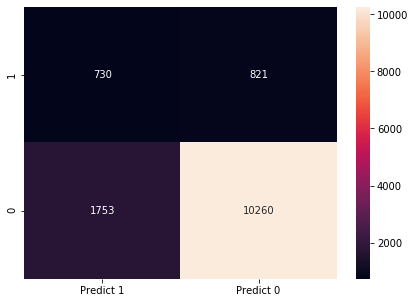

In [58]:
# Draw the confusion matrix for Logistic Regression
pred1 = log_reg.predict(xtest_sm_sc)
cm=metrics.confusion_matrix(ytest_sm, pred1, labels=[1, 0])
df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])

plt.figure(figsize = (7,5))
hm2 = sns.heatmap(df_cm, annot=True, fmt='g')
bottom, top = hm2.get_ylim()
hm2.set_ylim (bottom +0.5, top - 0.5)

**Analysis of Confusion Matrix -**

**True Positives (TP):** The model correctly predicted that 730 (444#) people will subscribe to Term Deposit. 

**True Negatives (TN):** The model correctly predicted that 10260 (11737#) people will not subscribe to Term Deposit.

**False Positives (FP):** The model incorrectly predicted that 1753 (276#) people will subscribe to Term Deposit, but they did not subscribe to Term Deposit. **("Type I error")**

**False Negatives (FN):** The model incorrectly predicted that 821 (1107#) people will not subscribe to Term Deposit, but they have subscribed to Term Deposit. **("Type II error")** 

   **# Denotes numbers before SMOTE. This shows model has predicted better after applying SMOTE.**

In [59]:
# StratifiedKfold is used to maintain the original data ratio in each folds. 
# Below code will split the data in 20 folds, and run the model 20 times. 

kfold = StratifiedKFold(n_splits=20)
cv_logistic = cross_val_score(log_reg, x_sc, y2, cv=kfold)
print("Cross Validation Score of Logistic Regression Model: ", round(cv_logistic.mean() * 100,2))

Cross Validation Score of Logistic Regression Model:  88.41


**Logistic regression model has been able to predict 88% with different combinations of training and test set of the dataset.**

In [150]:
cv_log = cv_logistic.mean()
f1_log = metrics.f1_score(ytest_sm, pred1, average='micro')
tn_log, fp_log, fn_log, tp_log = metrics.confusion_matrix(ytest_sm, pred1).ravel()

In [139]:
print("Classification Report For Logistic Regression (BEFORE SMOTE)")
print("")
print(LR_log)
print("--------------------------------------------------------------")
print("Classification Report For Logistic Regression (AFTER SMOTE)")
print("")
LR2_log = metrics.classification_report(ytest_sm, pred1, labels = [1,0])
print(LR2_log)

Classification Report For Logistic Regression (BEFORE SMOTE)

              precision    recall  f1-score   support

           1       0.62      0.29      0.39      1551
           0       0.91      0.98      0.94     12013

    accuracy                           0.90     13564
   macro avg       0.77      0.63      0.67     13564
weighted avg       0.88      0.90      0.88     13564

--------------------------------------------------------------
Classification Report For Logistic Regression (AFTER SMOTE)

              precision    recall  f1-score   support

           1       0.29      0.47      0.36      1551
           0       0.93      0.85      0.89     12013

    accuracy                           0.81     13564
   macro avg       0.61      0.66      0.63     13564
weighted avg       0.85      0.81      0.83     13564



**NOTE:** When classfication report is compared between BEFORE/AFTER SMOTE, Recall has been significantly improved in AFTER SMOTE. 

**AFTER SMOTE REPORT ANALYSIS** 


**Precision** [ TP/(TP + FP) => 730/(730+1753) => 0.29 ] => **Out of total positives predicted, 29% were predicted correctly.**

**Recall** [ TP/(TP + FN) => 730/(730+821) => 0.47 ]   => **Out of actual positives, 47% were predicted correctly.**

**Accuracy** [ (TP +TN)/(TP + TN + FP + FN) => (730 + 10260)/(730 + 10260 + 1753 + 821) => 0.81 ] => **Model has accuracy of 81%.**

**F1 Score** [2 * (precision * recall) / (precision + recall) => 2 * (0.29 * 0.47)/(0.29 + 0.47) => 0.36] => **Weighted average of precision and recall is 0.36**

### 2. K-NearestNeighbour

In [61]:
print("K values as per formula sqrt(n) : ", round(math.sqrt(xtrain_sm.shape[0])))

K values as per formula sqrt(n) :  236


In [62]:
# Tuning of KNN

KNC = KNeighborsClassifier(weights = 'distance')
neighb1 = (3,5,7,147,149,171,173,231,233,235,237,239,241) 
hyperparm2 = dict(n_neighbors=neighb1)

KNC_parms, KNC_score = parm_tune(KNC, hyperparm2, 20, xtrain_sm_sc, ytrain_sm)
print("Best Parameters Identified: \n", KNC_parms)
print("\nBest Score: \n", KNC_score)

Best Parameters Identified: 
 {'n_neighbors': 7}

Best Score: 
 0.8949442832061342


**RandomizedSearchCV on KNN provided the best K value as 7.** 

In [63]:
# Running the model again with n_neighbors=3
KNN3 = KNeighborsClassifier(n_neighbors=7,weights = 'distance')
KNN3.fit(xtrain_sm_sc, ytrain_sm)
KNN_TR = KNN3.score(xtrain_sm_sc,ytrain_sm)
KNN_TS = KNN3.score(xtest_sm_sc,ytest_sm)
print("KNN Model Training score with best possible k value : ", round(KNN_TR * 100, 2))
print("KNN Model Test score with best possible k value     : ", round(KNN_TS * 100, 2))

KNN Model Training score with best possible k value :  100.0
KNN Model Test score with best possible k value     :  84.14


**With default parameters, KNN model score is 82.9, and the KNN model score is 84.14 with best parameters.** 

**KNN took more time than logistic regression** 

In [64]:
# StratifiedKfold is used to maintain the original data ratio in each folds. 
# Below code will split the data in 20 folds, and run the model 20 times. 

kfold = StratifiedKFold(n_splits=20)
cv_knn = cross_val_score(KNN3, x_sc, y2, cv=kfold)
print("Cross Validation Score of KNN Model: ", round(cv_knn.mean() * 100,2))

Cross Validation Score of KNN Model:  81.45


**KNN model has been able to predict 82% with different combinations of training and test set of the dataset.**

(2.0, 0.0)

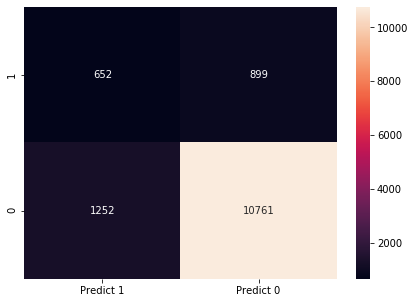

In [65]:
# Confustion Matrix
pred2 = KNN3.predict(xtest_sm_sc)

cm1=metrics.confusion_matrix(ytest_sm, pred2, labels=[1, 0])

df_cm = pd.DataFrame(cm1, index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (7,5))
hm2 = sns.heatmap(df_cm, annot=True, fmt='g')
bottom, top = hm2.get_ylim()
hm2.set_ylim (bottom +0.5, top - 0.5)

**Analysis of Confusion Matrix -**

**True Positives (TP):** The model correctly predicted that 652 people will subscribe to Term Deposit. 

**True Negatives (TN):** The model correctly predicted that 10761 people will not subscribe to Term Deposit.

**False Positives (FP):** The model incorrectly predicted that 1252 people will subscribe to Term Deposit, but they did not subscribe to Term Deposit. **("Type I error")**

**False Negatives (FN):** The model incorrectly predicted that 899 people will not subscribe to Term Deposit, but they have subscribed to Term Deposit. **("Type II error")**

In [151]:
cv_knn1 = cv_knn.mean()
f1_knn = metrics.f1_score(ytest_sm, pred2, average='micro')
tn_knn, fp_knn, fn_knn, tp_knn = metrics.confusion_matrix(ytest_sm, pred2).ravel()

In [66]:
print("Classification Report For KNN")
print("")
CR_KNN = metrics.classification_report(ytest_sm, pred2, labels = [1,0])
print(CR_KNN)

Classification Report For KNN

              precision    recall  f1-score   support

           1       0.34      0.42      0.38      1551
           0       0.92      0.90      0.91     12013

    accuracy                           0.84     13564
   macro avg       0.63      0.66      0.64     13564
weighted avg       0.86      0.84      0.85     13564



**Precision** [ TP/(TP + FP) => 652/(652+1252) => 0.34 ] => **Out of total positives predicted, 34% were predicted correctly.**  

**Recall** [ TP/(TP + FN) => 652/(652+899) => 0.42 ]   => **Out of actual positives, 42% were predicted correctly.**

**Accuracy** [ (TP +TN)/(TP + TN + FP + FN) => (652 + 10761)/(652 + 10761 + 1252 + 899) => 0.89 ] => **Model has accuracy of 84%.**

**F1 Score** [2 * (precision * recall) / (precision + recall) => 2 * (0.34 * 0.42)/(0.34 + 0.42) => 0.38] => **Weighted average of precision and recall is 0.89**

**NOTE: Based on classfication report observations, Logistic regression performs better than KNN.**

### 3. Gaussian Naive Bayes

In [67]:
GNM3 = GaussianNB()
GNM3.fit(xtrain_sm_sc,ytrain_sm)
GNM_TR = GNM3.score(xtrain_sm_sc,ytrain_sm)
GNM_TS = GNM3.score(xtest_sm_sc,ytest_sm)
print("Naive Bayes Training score : ", round(GNM_TR * 100, 2))
print("Naive Bayes Test score     : ", round(GNM_TS * 100, 2))

Naive Bayes Training score :  73.0
Naive Bayes Test score     :  58.59


**Noticeably, Gaussian Naive Bayes is the fastest algorithm, but the score is less than Logistic regression and KNN**

(2.0, 0.0)

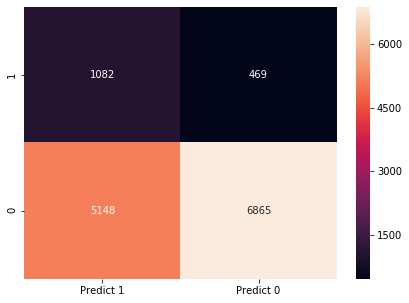

In [68]:
pred3 = GNM3.predict(xtest_sm_sc)

cm2=metrics.confusion_matrix(ytest_sm, pred3, labels=[1, 0])

df_cm_gnm = pd.DataFrame(cm2, index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (7,5))
hm3 = sns.heatmap(df_cm_gnm, annot=True, fmt='g')
bottom, top = hm3.get_ylim()
hm3.set_ylim (bottom +0.5, top - 0.5)

**Interesting Observation - When compared to LR and KNN, type 2 error is less, type 1 error is high.**

**True Positive (TP):** The model correctly predicted that 1082 people will subscribe to Term Deposit. **Gaussian NB's True Positive is greater than Logistic and K-NN**

**True Negative (TN):** The model correctly predicted that 6865 people will not subscribe to Term Deposit.

**False Positive (FP):** The model incorrectly predicted that 5148 people will subscribe to Term Deposit, but they did not subscribe to Term Deposit. **("Type I error")**

**False Negative (FN):** The model incorrectly predicted that 469 people will not subscribe to Term Deposit, but they have subscribed to Term Deposit. **Gaussian NB's False Negative is lesser than Logistic and K-NN.("Type II error")**

In [69]:
# StratifiedKfold is used to maintain the original data ratio in each folds. 
# Below code will split the data in 20 folds, and run the model 20 times. 

kfold = StratifiedKFold(n_splits=20)
cv_gnm = cross_val_score(GNM3, x_sc, y2, cv=kfold)
print("Cross Validation Score of Gaussian Naive Bayes Model: ", round(cv_gnm.mean() * 100,2))

Cross Validation Score of Gaussian Naive Bayes Model:  77.82


**Gaussian Naive Bayes model has been able to predict 78% with different combinations of training and test set of the dataset.** 

In [153]:
cv_gnm1 = cv_gnm.mean()
f1_gnm = metrics.f1_score(ytest_sm, pred3, average='micro')
tn_gnm, fp_gnm, fn_gnm, tp_gnm = metrics.confusion_matrix(ytest_sm, pred3).ravel()

In [70]:
print("Classification Report For Gaussian Naive Bayes")
print("")
CR_NB = metrics.classification_report(ytest_sm, pred3, labels = [1,0])
print(CR_NB)

Classification Report For Gaussian Naive Bayes

              precision    recall  f1-score   support

           1       0.17      0.70      0.28      1551
           0       0.94      0.57      0.71     12013

    accuracy                           0.59     13564
   macro avg       0.55      0.63      0.49     13564
weighted avg       0.85      0.59      0.66     13564



**Precision** [ TP/(TP + FP) => 1082/(1082+5148) => 0.67 ] => **Out of total positives predicted, 17% were predicted correctly.**  

**Recall** [ TP/(TP + FN) => 1082/(1082+469) => 0.70 ]   => **Out of actual positives, 70% were predicted correctly.**

**Accuracy** [ (TP +TN)/(TP + TN + FP + FN) => (1082 + 6865)/(1082 + 6865 + 5148 + 469) => 0.59 ] => **Model has accuracy of 59%.**

**F1 Score** [2 * (precision * recall) / (precision + recall) => 2 * (0.17 * 0.70)/(0.70 + 0.17) => 0.28] => **Weighted average of precision and recall is 0.28**

### 4. Decision Tree Classifier

In [71]:
DT3 = DecisionTreeClassifier(random_state=1)
DT3.fit(xtrain_sm_sc,ytrain_sm)
print("DecisionTree Classifier Test score with default parameters :", DT3.score(xtest_sm_sc,ytest_sm))

DecisionTree Classifier Test score with default parameters : 0.8114862872309053


In [72]:
DT3

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1, splitter='best')

In [73]:
#Tuning of Decision Tree Classifier

DTC = DecisionTreeClassifier(random_state=1)
hyperparm3 = {'criterion':['gini','entropy'],'max_depth': np.arange(3, 16), 'max_features': np.arange(4,17)}

DT1_parms, DT1_score = parm_tune(DTC, hyperparm3, 20, xtrain_sm_sc, ytrain_sm)
print("Best Parameters Identified: \n", DT1_parms)
print("\nBest Score: \n", DT1_score)

Best Parameters Identified: 
 {'max_features': 16, 'max_depth': 15, 'criterion': 'entropy'}

Best Score: 
 0.8743595256010606


* max_features denotes the number of columns can be used for branching. Default is all the columns would be considered for branching.


* max_depth denotes the depth of tree. Default is braching would happen until last leaf/last value from input.


* criterion 'entropy' denotes the information gain. 

In [74]:
DT4 = DecisionTreeClassifier(criterion = 'entropy',max_depth = 14, max_features = 16, random_state=1)
DT4.fit(xtrain_sm_sc,ytrain_sm)
DT4_TR = DT4.score(xtrain_sm_sc,ytrain_sm)
DT4_TS = DT4.score(xtest_sm_sc,ytest_sm)
print("Decistion Tree Training score with best hyperparameters : ", round(DT4_TR * 100, 2))
print("Decistion Tree Test score with best hyperparameters     : ", round(DT4_TS * 100, 2))

Decistion Tree Training score with best hyperparameters :  91.09
Decistion Tree Test score with best hyperparameters     :  85.06


**With default parameters, Decision Tree model score is 81, and the score is 85 with best parameters. Significant increase in model score with hyperparameters chosen by RandomizedSearchCV.** 

(2.0, 0.0)

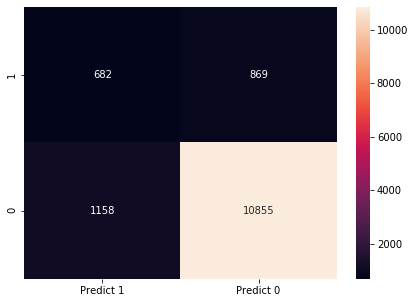

In [75]:
pred4 = DT4.predict(xtest_sm_sc)

cm3=metrics.confusion_matrix(ytest_sm, pred4, labels=[1, 0])

df_cm = pd.DataFrame(cm3, index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (7,5))
hm3 = sns.heatmap(df_cm, annot=True, fmt='g')
bottom, top = hm3.get_ylim()
hm3.set_ylim (bottom +0.5, top - 0.5)

**Analysis of Confusion Matrix -**

**True Positives (TP):** The model correctly predicted that 682 people will subscribe to Term Deposit. 

**True Negatives (TN):** The model correctly predicted that 10855 people will not subscribe to Term Deposit.

**False Positives (FP):** The model incorrectly predicted that 1158 people will subscribe to Term Deposit, but they did not subscribe to Term Deposit. **("Type I error")**

**False Negatives (FN):** The model incorrectly predicted that 869 people will not subscribe to Term Deposit, but they have subscribed to Term Deposit. **("Type II error")**

In [76]:
# StratifiedKfold is used to maintain the original data ratio in each folds. 
# Below code will split the data in 20 folds, and run the model 100 times. 

kfold = StratifiedKFold(n_splits=100)
cv_dt = cross_val_score(DT4, x_sc, y2, cv=kfold)
print("Cross Validation Score of Decision Tree Model: ", round(cv_dt.mean() * 100,2))

Cross Validation Score of Decision Tree Model:  81.16


**Decision tree model has been able to predict 81% with different combinations of training and test set of the dataset.**

In [156]:
cv_dt1 = cv_dt.mean() 
f1_dt = metrics.f1_score(ytest_sm, pred4, average='micro')
tn_dt, fp_dt, fn_dt, tp_dt = metrics.confusion_matrix(ytest_sm, pred4).ravel()

In [77]:
print("Classification Report For Decision Tree classifier")
print("")
CR_DT = metrics.classification_report(ytest_sm, pred4, labels = [1,0])
print(CR_DT)

Classification Report For Decision Tree classifier

              precision    recall  f1-score   support

           1       0.37      0.44      0.40      1551
           0       0.93      0.90      0.91     12013

    accuracy                           0.85     13564
   macro avg       0.65      0.67      0.66     13564
weighted avg       0.86      0.85      0.86     13564



**Precision** [ TP/(TP + FP) => 682/(682+1158) => 0.37 ] => **Out of total positives predicted, 37% were predicted correctly.** 

**Recall** [ TP/(TP + FN) => 682/(682+869) => 0.44 ]   => **Out of actual positives, 44% were predicted correctly.**

**Accuracy** [ (TP +TN)/(TP + TN + FP + FN) => (682 + 10855)/(682 + 10855 + 1158 + 869) => 0.85 ] => **Model has accuracy of 85%.**

**F1 Score** [2 * (precision * recall) / (precision + recall) => 2 * (0.37 * 0.44)/(0.37 + 0.44) => 0.40] => **Weighted average of precision and recall is 0.40**

## Ensemble Techniques

### 5. Random Forest Classfier

In [78]:
# with default hyperparameters
RFCL1 = RandomForestClassifier(random_state = 1)
RFCL1.fit(xtrain_sm_sc,ytrain_sm)
RFCL1_TR = RFCL1.score(xtrain_sm_sc,ytrain_sm)
RFCL1_TS = RFCL1.score(xtest_sm_sc,ytest_sm)
print("Random Forest Classifier Training score with default parameters : ", round(RFCL1_TR * 100, 2))
print("Random Forest Classifier Test score with default parameters     : ", round(RFCL1_TS * 100, 2))

Random Forest Classifier Training score with default parameters :  99.28
Random Forest Classifier Test score with default parameters     :  87.39


##### Tuning of Random Forest Classifier

In [79]:
RFC = RandomForestClassifier(random_state = 1)
hyperparm4 = {'n_estimators': np.arange(49,54), 'criterion':['gini','entropy'],'max_features': np.arange(5,8)}
# various Parameters range were tried to get score better than default parameters score

RF1_parms, RF1_score = parm_tune(RFC, hyperparm4, 20, xtrain_sm_sc, ytrain_sm)
print("Best Parameters Identified: \n", RF1_parms)
print("\nBest Score: \n", RF1_score)

Best Parameters Identified: 
 {'n_estimators': 50, 'max_features': 7, 'criterion': 'entropy'}

Best Score: 
 0.9153319717653804


* max_features denotes the number of columns can be used for branching. Default is all the columns would be considered for branching.


* n_estimators denotes the number of underlying decistion trees to be built. Default value is 10 (i.e. 10 trees would be built)


* criterion 'entropy' denotes the information gain. 

In [80]:
RFCL2 = RandomForestClassifier(n_estimators = 50, criterion = 'gini', max_features = 7, random_state=1)
RFCL2.fit(xtrain_sm_sc,ytrain_sm)
RFCL2_TR = RFCL2.score(xtrain_sm_sc,ytrain_sm)
RFCL2_TS = RFCL2.score(xtest_sm_sc,ytest_sm)
print("Random Forest Classifier Training score with best hyperparameters : ", round(RFCL2_TR * 100, 2))
print("Random Forest Classifier Test score with best hyperparameters     : ", round(RFCL2_TS * 100, 2))

Random Forest Classifier Training score with best hyperparameters :  99.97
Random Forest Classifier Test score with best hyperparameters     :  87.42


**With default parameters, Random Forest score is 87.39, and the score is 87.42 with best parameters. No Significant increase in model score with hyperparameters chosen by RandomizedSearchCV.** 

(2.0, 0.0)

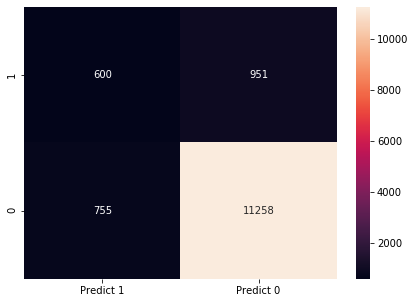

In [81]:
pred6 = RFCL2.predict(xtest_sm_sc)

cm3=metrics.confusion_matrix(ytest_sm, pred6, labels=[1, 0])

df_cm = pd.DataFrame(cm3, index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (7,5))
hm3 = sns.heatmap(df_cm, annot=True, fmt='g')
bottom, top = hm3.get_ylim()
hm3.set_ylim (bottom +0.5, top - 0.5)

**Analysis of Confusion Matrix -**

**True Positives (TP):** The model correctly predicted that 600 people will subscribe to Term Deposit. 

**True Negatives (TN):** The model correctly predicted that 11258 people will not subscribe to Term Deposit.

**False Positives (FP):** The model incorrectly predicted that 755 people will subscribe to Term Deposit, but they did not subscribe to Term Deposit. **("Type I error")**

**False Negatives (FN):** The model incorrectly predicted that 951 people will not subscribe to Term Deposit, but they have subscribed to Term Deposit. **("Type II error")**

In [82]:
# StratifiedKfold is used to maintain the original data ratio in each folds. 
# Below code will split the data in 20 folds, and run the model 20 times. 

kfold = StratifiedKFold(n_splits=50)
cv_rfcl = cross_val_score(RFCL2, x_sc, y2, cv=kfold)
print("Cross Validation Score of Random Forest Model: ", round(cv_rfcl.mean() * 100,2))

Cross Validation Score of Random Forest Model:  75.71


**Random forest algorithm has been able to predict 78% with different combinations of training and test set of the dataset.**

In [161]:
cv_rfcl1 = cv_rfcl.mean()
f1_rfcl = metrics.f1_score(ytest_sm, pred6, average='micro')
tn_rfcl, fp_rfcl, fn_rfcl, tp_rfcl = metrics.confusion_matrix(ytest_sm, pred6).ravel()

In [83]:
print("Classification Report For Random Forest classifier with best hyper parameters")
print("")
CR_RF2 = metrics.classification_report(ytest_sm, pred6, labels = [1,0])
print(CR_RF2)

Classification Report For Random Forest classifier with best hyper parameters

              precision    recall  f1-score   support

           1       0.44      0.39      0.41      1551
           0       0.92      0.94      0.93     12013

    accuracy                           0.87     13564
   macro avg       0.68      0.66      0.67     13564
weighted avg       0.87      0.87      0.87     13564



**Precision** [ TP/(TP + FP) => 600/(600+755) => 0.44 ] => **Out of total positives predicted, 44% were predicted correctly.**  

**Recall** [ TP/(TP + FN) => 600/(600+951) => 0.39 ]   => **Out of actual positives, 39% were predicted correctly.**

**Accuracy** [ (TP +TN)/(TP + TN + FP + FN) => (600 + 11258)/(600 + 11258 + 755 + 951) => 0.87 ] => **Model has accuracy of 92%.**

**F1 Score** [2 * (precision * recall) / (precision + recall) => 2 * (0.44 * 0.39)/(0.39 + 0.44) => 0.41] => **Weighted average of precision and recall is 0.91**

### 6. Bagging Classifier

In [84]:
BC1 = BaggingClassifier(max_samples =.7, n_jobs = -1)
BC1.fit(xtrain_sm_sc,ytrain_sm)
BC1_TR = BC1.score(xtrain_sm_sc,ytrain_sm)
BC1_TS = BC1.score(xtest_sm_sc,ytest_sm)
print("Bagging Classifier Training score with default parameters : ", round(BC1_TR * 100, 2))
print("Bagging Classifier Test score with default parameters     : ", round(BC1_TS * 100, 2))

Bagging Classifier Training score with default parameters :  98.19
Bagging Classifier Test score with default parameters     :  86.57


#### Tuning Bagging classifier

In [85]:
BC2 = BaggingClassifier(max_samples =.7, n_jobs = -1)
hyperparm5 = {'n_estimators':[50, 100], 'max_features' : np.arange(8,10)}
# various Parameters range were tried to get score better than default parameters score

BC1_parms, BC1_score = parm_tune(BC2, hyperparm5, 20, xtrain_sm_sc, ytrain_sm)
print("Best Parameters Identified: \n", BC1_parms)
print("\nBest Score: \n", BC1_score)

Best Parameters Identified: 
 {'n_estimators': 100, 'max_features': 9}

Best Score: 
 0.9209573972553656


* n_estimators denotes the number of underlying decistion trees to be built. Default value is 10 (i.e. 10 trees would be built)


* max_features denotes the number of columns can be used for branching. Default is all the columns would be considered for branching.

In [86]:
BC3 = BaggingClassifier(n_estimators = 100,max_features = 9, max_samples =.7, n_jobs = -1)
BC3.fit(xtrain_sm_sc,ytrain_sm)
BC3_TR = BC3.score(xtrain_sm_sc,ytrain_sm)
BC3_TS = BC3.score(xtest_sm_sc,ytest_sm)
print("Bagging Classifier Training score with best hyper parameters) : ", round(BC3_TR * 100, 2))
print("Bagging Classifier Test score with best hyper parameters)     : ", round(BC3_TS * 100, 2))

Bagging Classifier Training score with best hyper parameters) :  99.12
Bagging Classifier Test score with best hyper parameters)     :  87.48


**With default parameters, Bagging classifier score is 86.57, and the score is 87.48 with best parameters. There is a slight increase in model score with hyperparameters chosen by RandomizedSearchCV**

(2.0, 0.0)

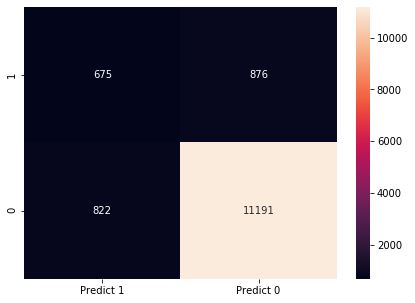

In [87]:
pred7 = BC3.predict(xtest_sm_sc)

cm3=metrics.confusion_matrix(ytest_sm, pred7, labels=[1, 0])

df_cm = pd.DataFrame(cm3, index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (7,5))
hm3 = sns.heatmap(df_cm, annot=True, fmt='g')
bottom, top = hm3.get_ylim()
hm3.set_ylim (bottom +0.5, top - 0.5)

**Analysis of Confusion Matrix -**

**True Positives (TP):** The model correctly predicted that 690 people will subscribe to Term Deposit. 

**True Negatives (TN):** The model correctly predicted that 11208 people will not subscribe to Term Deposit.

**False Positives (FP):** The model incorrectly predicted that 805 people will subscribe to Term Deposit, but they did not subscribe to Term Deposit. **("Type I error")**

**False Negatives (FN):** The model incorrectly predicted that 861 people will not subscribe to Term Deposit, but they have subscribed to Term Deposit. **("Type II error")**

In [88]:
# StratifiedKfold is used to maintain the original data ratio in each folds. 
# Below code will split the data in 20 folds, and run the model 20 times. 

kfold = StratifiedKFold(n_splits=50)
cv_bc = cross_val_score(BC3, x_sc, y2, cv=kfold)
print("Cross Validation Score of Bagging Classifier Model: ", round(cv_bc.mean() * 100,2))

Cross Validation Score of Bagging Classifier Model:  86.47


**Bagging Classifier has been able to predict 86.5% with different combinations of training and test set of the dataset.** 

In [162]:
cv_bc1 = cv_bc.mean()
f1_bc = metrics.f1_score(ytest_sm, pred7, average='micro')
tn_bc, fp_bc, fn_bc, tp_bc = metrics.confusion_matrix(ytest_sm, pred7).ravel()

In [89]:
print("Classification Report For Bagging classifier ")
print("")
CR_BC = metrics.classification_report(ytest_sm, pred7, labels = [1,0])
print(CR_BC)

Classification Report For Bagging classifier 

              precision    recall  f1-score   support

           1       0.45      0.44      0.44      1551
           0       0.93      0.93      0.93     12013

    accuracy                           0.87     13564
   macro avg       0.69      0.68      0.69     13564
weighted avg       0.87      0.87      0.87     13564



**Precision** [ TP/(TP + FP) => 690/(690+805) => 0.46 ] => **Out of total positives predicted, 46% were predicted correctly.**  

**Recall** [ TP/(TP + FN) => 690/(690+861) => 0.44 ]   => **Out of actual positives, 44% were predicted correctly.**

**Accuracy** [ (TP +TN)/(TP + TN + FP + FN) => (690 + 11208)/(690 + 11208 + 805 + 861) => 0.88 ] => **Model has accuracy of 88%.**

**F1 Score** [2 * (precision * recall) / (precision + recall) => 2 * (0.46 * 0.44)/(0.46 + 0.44) => 0.45] => **Weighted average of precision and recall is 0.45**

### 7. Bagging Classfier (with underlying Gaussian Naive Bayes model)

### Among the models I have tried  (LR, KNN, GNB, DT), Gaussian Naive Bayes is the weakest one in terms of accuracy. Therefore, I am going to apply GNB as underlying model in Bagging Classifier.  

In [90]:
BC1_GNB = BaggingClassifier(base_estimator = GNM3, max_samples =.7, n_jobs = -1)
BC1_GNB.fit(xtrain_sm_sc,ytrain_sm)
BC1_GNB_TR = BC1_GNB.score(xtrain_sm_sc,ytrain_sm)
BC1_GNB_TS = BC1_GNB.score(xtest_sm_sc,ytest_sm)
print("Bagging Classifier Training score with default parameters (with underlying GNB) : ", round(BC1_GNB_TR * 100, 2))
print("Bagging Classifier Test score with default parameters (with underlying GNB)     : ", round(BC1_GNB_TS * 100, 2))

Bagging Classifier Training score with default parameters (with underlying GNB) :  72.97
Bagging Classifier Test score with default parameters (with underlying GNB)     :  58.62


#### Tuning of BC with underlying GNB

In [91]:
BC2_GNB = BaggingClassifier(base_estimator = GNM3, max_samples =.7, n_jobs = -1)
hyperparm6 = {'n_estimators':[40, 50], 'max_features' : np.arange(5,7)}
# various Parameters range were tried to get score better than default parameters score

BC2_GNB_parms, BC2_GNB_score = parm_tune(BC2_GNB, hyperparm6, 10, xtrain_sm_sc, ytrain_sm)
print("Best Parameters Identified: \n", BC2_GNB_parms)

Best Parameters Identified: 
 {'n_estimators': 50, 'max_features': 6}


* n_estimators denotes the number of underlying decistion trees to be built. Default value is 10 (i.e. 10 trees would be built)


* max_features denotes the number of columns can be used for branching. Default is all the columns would be considered for branching.

In [92]:
BC3_GNB = BaggingClassifier(base_estimator = GNM3, n_estimators = 40, max_features = 6, max_samples =.7, n_jobs = -1)
BC3_GNB.fit(xtrain_sm_sc,ytrain_sm)
BC3_GNB_TR = BC3_GNB.score(xtrain_sm_sc,ytrain_sm)
BC3_GNB_TS = BC3_GNB.score(xtest_sm_sc,ytest_sm)
print("Bagging Classifier Training score with best hyper parameters (with underlying GNB) : ", round(BC3_GNB_TR * 100, 2))
print("Bagging Classifier Test score with best hyper parameters (with underlying GNB)     : ", round(BC3_GNB_TS * 100, 2))

Bagging Classifier Training score with best hyper parameters (with underlying GNB) :  71.76
Bagging Classifier Test score with best hyper parameters (with underlying GNB)     :  54.69


**NOTE:** 

* **Various parameters ranges were tried and Confusion matrix was built for each attempt. I have got better accuracy scores with parameters provided by RandomizedSearchCV. However, there is no much difference to values in Confusion matrix. Due to this reason, parameters with higher scores were ignored.**


* **Though the score 53.72 is less than score (58.67) with default parameters, I am proceeding with this model due to significant improvement in True positives and False Negatives.**


In [93]:
pred8 = BC3_GNB.predict(xtest_sm_sc)

cm3=metrics.confusion_matrix(ytest_sm, pred8, labels=[1, 0])

df_cm_bcgnm = pd.DataFrame(cm3, index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])

Text(0.5, 1, 'Gaussian Naive Bayes')

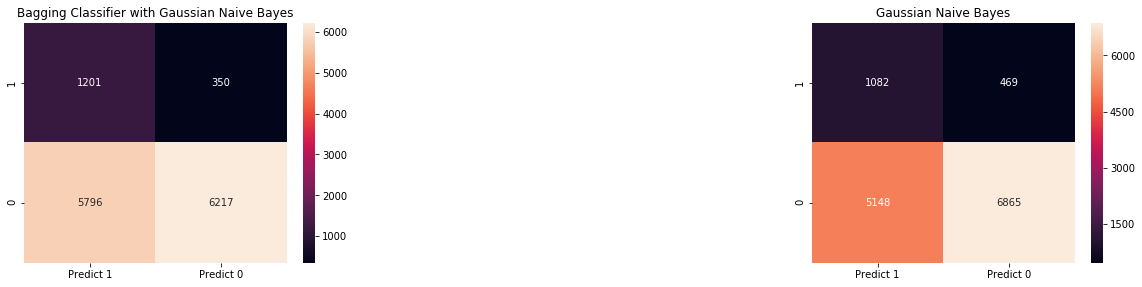

In [94]:
plt.figure(figsize = (20,15))
plt.subplot(3,3,1)
hm2 = sns.heatmap(df_cm_bcgnm, annot=True, fmt='g')
bottom, top = hm2.get_ylim()
hm2.set_ylim (bottom +0.5, top - 0.5)
plt.title("Bagging Classifier with Gaussian Naive Bayes")

plt.subplot(3,3,3)
hm3 = sns.heatmap(df_cm_gnm, annot=True, fmt='g')
bottom, top = hm3.get_ylim()
hm3.set_ylim (bottom +0.5, top - 0.5)
plt.title("Gaussian Naive Bayes")

**Interesting Observations -**

* **When compared to GNB, Bagging classifier(with GNB) model has better values in True Positives and False Negatives.**


* **This model the best True Positives and False Negatives when compared to the models I have tried until now.** 


* **At the same time, this model has the poorest True Negatives and False Positives.** 

-------------------------------------------------------------------------------------------------------------------------------

**True Positive (TP):** The model correctly predicted that 1218 people will subscribe to Term Deposit. 

**True Negative (TN):** The model correctly predicted that 6068 people will not subscribe to Term Deposit.

**False Positive (FP):** The model incorrectly predicted that 5945 people will subscribe to Term Deposit, but they did not subscribe to Term Deposit. **("Type I error")**

**False Negative (FN):** The model incorrectly predicted that 333 people will not subscribe to Term Deposit, but they have subscribed to Term Deposit. **("Type II error")**

In [95]:
# StratifiedKfold is used to maintain the original data ratio in each folds. 
# Below code will split the data in 20 folds, and run the model 20 times. 

kfold = StratifiedKFold(n_splits=50)
cv_bcgnb = cross_val_score(BC3_GNB, x_sc, y2, cv=kfold)
print("Cross Validation Score of Bagging Classifier (with underlying Gaussian Naive Bayes): ", round(cv_bcgnb.mean() * 100,2))

Cross Validation Score of Bagging Classifier (with underlying Gaussian Naive Bayes):  87.42


**Bagging Classifier (with underlying GNB) has been able to predict 87% with different combinations of training and test set of the dataset. The cross validation score is much higher than model score. This shows the model is performing well consistently with different sets of data.** 

In [164]:
cv_bcgn = cv_bcgnb.mean()
f1_bcgn = metrics.f1_score(ytest_sm, pred8, average='micro')
tn_bcgn, fp_bcgn, fn_bcgn, tp_bcgn = metrics.confusion_matrix(ytest_sm, pred8).ravel()

In [96]:
print("Classification Report For Bagging classifier( with GNB) ")
print("")
CR_BC_GNM = metrics.classification_report(ytest_sm, pred8, labels = [1,0])
print(CR_BC_GNM)

Classification Report For Bagging classifier( with GNB) 

              precision    recall  f1-score   support

           1       0.17      0.77      0.28      1551
           0       0.95      0.52      0.67     12013

    accuracy                           0.55     13564
   macro avg       0.56      0.65      0.48     13564
weighted avg       0.86      0.55      0.62     13564



**Precision** [ TP/(TP + FP) => 1218/(1218+5945) => 0.17 ] => **Out of total positives predicted, 17% were predicted correctly.**  

**Recall** [ TP/(TP + FN) => 1218/(1218+333) => 0.79 ]   => **Out of actual positives, 79% were predicted correctly.**

**Accuracy** [ (TP +TN)/(TP + TN + FP + FN) => (1218 + 6068)/(1218 + 6068 + 333 + 5945) => 0.54 ] => **Model has accuracy of 54%.**

**F1 Score** [2 * (precision * recall) / (precision + recall) => 2 * (0.17 * 0.79)/(0.17 + 0.79) => 0.28] => **Weighted average of precision and recall is 0.45**

### 8. AdaBoost Classifier

In [97]:
AC2 = AdaBoostClassifier(learning_rate=0.1)
AC2.fit(xtrain_sm_sc,ytrain_sm)
AC2_TR = AC2.score(xtrain_sm_sc,ytrain_sm)
AC2_TS = AC2.score(xtest_sm_sc,ytest_sm)
print("Adaboost Classifier Training score with default parameters : ", round(AC2_TR * 100, 2))
print("Adaboost Classifier Test score with default parameters     : ", round(AC2_TS * 100, 2))

Adaboost Classifier Training score with default parameters :  78.84
Adaboost Classifier Test score with default parameters     :  70.86


In [98]:
# Tuning of AdaBoost Classifier

hyperparm7 = {'n_estimators':[25, 75, 100]}
AC1_parms, AC1_score = parm_tune(AC2, hyperparm7, 10, xtrain_sm_sc, ytrain_sm)
print("Best Parameters Identified: \n", AC1_parms)

Best Parameters Identified: 
 {'n_estimators': 100}


* n_estimators denotes the number of underlying decistion trees to be built. Default value is 10 (i.e. 10 trees would be built)

In [99]:
AC3 = AdaBoostClassifier(n_estimators = 100, learning_rate=0.1)
AC3.fit(xtrain_sm_sc,ytrain_sm)
AC3_TR = AC3.score(xtrain_sm_sc,ytrain_sm)
AC3_TS = AC3.score(xtest_sm_sc,ytest_sm)
print("Adaboost Classifier Training score with best parameters : ", round(AC3_TR * 100, 2))
print("Adaboost Classifier Test score with best parameters     : ", round(AC3_TS * 100, 2))

Adaboost Classifier Training score with best parameters :  82.06
Adaboost Classifier Test score with best parameters     :  76.13


**With default parameters, AdaBoost classifier score is 70.86, and the score is 76.13 with best parameters. There is a significant increase in model score with hyperparameters chosen by RandomizedSearchCV**

(2.0, 0.0)

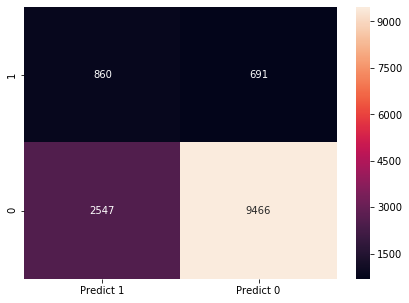

In [100]:
pred9 = AC3.predict(xtest_sm_sc)

cm3=metrics.confusion_matrix(ytest_sm, pred9, labels=[1, 0])

df_ac = pd.DataFrame(cm3, index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (7,5))
hm3 = sns.heatmap(df_ac, annot=True, fmt='g')
bottom, top = hm3.get_ylim()
hm3.set_ylim (bottom +0.5, top - 0.5)

**True Positive (TP):** The model correctly predicted that 860 people will subscribe to Term Deposit. 

**True Negative (TN):** The model correctly predicted that 9466 people will not subscribe to Term Deposit.

**False Positive (FP):** The model incorrectly predicted that 2547 people will subscribe to Term Deposit, but they did not subscribe to Term Deposit. **("Type I error")**

**False Negative (FN):** The model incorrectly predicted that 691 people will not subscribe to Term Deposit, but they have subscribed to Term Deposit. **("Type II error")**

In [117]:
# StratifiedKfold is used to maintain the original data ratio in each folds. 
# Below code will split the data in 50 folds, and run the model 20 times. 

kfold = StratifiedKFold(n_splits=50)
cv_ac = cross_val_score(AC3, x_sc, y2, cv=kfold)
print("Cross Validation Score of Adaptive Boosting Classifier : ", round(cv_ac.mean() * 100,2))

Cross Validation Score of Adaptive Boosting Classifier :  88.94


**AdaBoost Classifier has been able to predict 88.9% with different combinations of training and test set of the dataset. The cross validation score is much higher than model score. This shows the model is performing well consistently with different sets of data.** 

In [166]:
cv_ac1 = cv_ac.mean() 
f1_ac = metrics.f1_score(ytest_sm, pred9, average='micro')
tn_ac, fp_ac, fn_ac, tp_ac = metrics.confusion_matrix(ytest_sm, pred9).ravel()

In [101]:
print("Classification Report For AdaBoost classifier ")
print("")
CR_AC = metrics.classification_report(ytest_sm, pred9, labels = [1,0])
print(CR_AC)

Classification Report For AdaBoost classifier 

              precision    recall  f1-score   support

           1       0.25      0.55      0.35      1551
           0       0.93      0.79      0.85     12013

    accuracy                           0.76     13564
   macro avg       0.59      0.67      0.60     13564
weighted avg       0.85      0.76      0.80     13564



**Precision** [ TP/(TP + FP) => 860/(860+2547) => 0.25 ] => **Out of total positives predicted, 25% were predicted correctly.**  

**Recall** [ TP/(TP + FN) => 860/(860+691) => 0.55 ]   => **Out of actual positives, 55% were predicted correctly.**

**Accuracy** [ (TP +TN)/(TP + TN + FP + FN) => (860 + 9466)/(860 + 9466 + 691 + 2547) => 0.76 ] => **Model has accuracy of 76%.**

**F1 Score** [2 * (precision * recall) / (precision + recall) => 2 * (0.25 * 0.55)/(0.25 + 0.55) => 0.35] => **Weighted average of precision and recall is 0.35**

### 9. AdaBoost Classifier (With GNB)

In [102]:
AC1_GNB = AdaBoostClassifier(base_estimator = GNM3,learning_rate=0.1)
AC1_GNB.fit(xtrain_sm_sc,ytrain_sm)
AC1_GNB_TR = AC1_GNB.score(xtrain_sm_sc,ytrain_sm)
AC1_GNB_TS = AC1_GNB.score(xtest_sm_sc,ytest_sm)
print("Adaboost Classifier Training score with default parameters (with underlying GNB) : ", round(AC1_GNB_TR * 100, 2))
print("Adaboost Classifier Test score with default parameters (with underlying GNB)     : ", round(AC1_GNB_TS * 100, 2))

Adaboost Classifier Training score with default parameters (with underlying GNB) :  83.01
Adaboost Classifier Test score with default parameters (with underlying GNB)     :  76.64


#### Tuning of Adaboost classifier (with GNB)

In [103]:
hyperparm7 = {'n_estimators':[25, 75, 100]}
# various Parameters range were tried to get score better than default parameters score

AC1_GNB_parms, AC1_GNB_score = parm_tune(AC1_GNB, hyperparm7, 10, xtrain_sm_sc, ytrain_sm)
print("Best Parameters Identified: \n", AC1_GNB_parms)

Best Parameters Identified: 
 {'n_estimators': 100}


* n_estimators denotes the number of underlying decistion trees to be built. Default value is 10 (i.e. 10 trees would be built)

In [104]:
AC2_GNB = AdaBoostClassifier(base_estimator = GNM3,n_estimators = 100, learning_rate=0.1)
AC2_GNB.fit(xtrain_sm_sc,ytrain_sm)
AC2_GNB_TR = AC2_GNB.score(xtrain_sm_sc,ytrain_sm)
AC2_GNB_TS = AC2_GNB.score(xtest_sm_sc,ytest_sm)
print("Adaboost Classifier Training score with default parameters (with underlying GNB) : ", round(AC2_GNB_TR * 100, 2))
print("Adaboost Classifier Test score with default parameters (with underlying GNB)     : ", round(AC2_GNB_TS * 100, 2))

Adaboost Classifier Training score with default parameters (with underlying GNB) :  83.45
Adaboost Classifier Test score with default parameters (with underlying GNB)     :  77.75


**With default parameters, AdaBoost classifier score is 76.64, and the score is 77.75 with best parameters. There is a slight increase in model score with hyperparameters chosen by RandomizedSearchCV**

(2.0, 0.0)

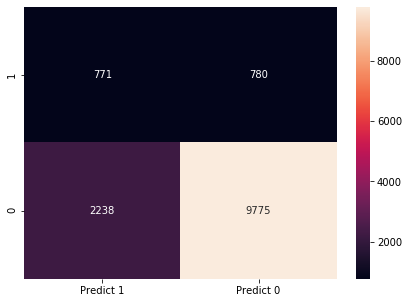

In [105]:
pred10 = AC2_GNB.predict(xtest_sm_sc)

cm3=metrics.confusion_matrix(ytest_sm, pred10, labels=[1, 0])

df_acgnb = pd.DataFrame(cm3, index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (7,5))
hm3 = sns.heatmap(df_acgnb, annot=True, fmt='g')
bottom, top = hm3.get_ylim()
hm3.set_ylim (bottom +0.5, top - 0.5)

**True Positive (TP):** The model correctly predicted that 771 people will subscribe to Term Deposit. 

**True Negative (TN):** The model correctly predicted that 9775 people will not subscribe to Term Deposit.

**False Positive (FP):** The model incorrectly predicted that 2238 people will subscribe to Term Deposit, but they did not subscribe to Term Deposit. **("Type I error")**

**False Negative (FN):** The model incorrectly predicted that 780 people will not subscribe to Term Deposit, but they have subscribed to Term Deposit. **("Type II error")**

In [118]:
# StratifiedKfold is used to maintain the original data ratio in each folds. 
# Below code will split the data in 50 folds, and run the model 20 times. 

kfold = StratifiedKFold(n_splits=50)
cv_acgnb = cross_val_score(AC2_GNB, x_sc, y2, cv=kfold)
print("Cross Validation Score of Adaptive Boosting Classifier (With GNB) : ", round(cv_acgnb.mean() * 100,2))

Cross Validation Score of Adaptive Boosting Classifier (With GNB) :  87.02


**Adaptive Boosting Classifier (with underlying GNB) has been able to predict 87.02% with different combinations of training and test set of the dataset. The cross validation score is much higher than model score. This shows the model is performing well consistently with different sets of data.** 

In [169]:
cv_acgn = cv_acgnb.mean()
f1_acgn = metrics.f1_score(ytest_sm, pred10, average='micro')
tn_acgn, fp_acgn, fn_acgn, tp_acgn = metrics.confusion_matrix(ytest_sm, pred10).ravel()

In [106]:
print("Classification Report For AdaBoost classifier (with GNB) ")
print("")
CR_AC_GNB = metrics.classification_report(ytest_sm, pred10, labels = [1,0])
print(CR_AC_GNB)

Classification Report For AdaBoost classifier (with GNB) 

              precision    recall  f1-score   support

           1       0.26      0.50      0.34      1551
           0       0.93      0.81      0.87     12013

    accuracy                           0.78     13564
   macro avg       0.59      0.66      0.60     13564
weighted avg       0.85      0.78      0.81     13564



**Precision** [ TP/(TP + FP) => 771/(771+2238) => 0.26 ] => **Out of total positives predicted, 26% were predicted correctly.**  

**Recall** [ TP/(TP + FN) => 771/(771+780) => 0.50 ]   => **Out of actual positives, 50% were predicted correctly.**

**Accuracy** [ (TP +TN)/(TP + TN + FP + FN) => (771 + 9775)/(771 + 9775 + 780 + 2238) => 0.78 ] => **Model has accuracy of 78%.**

**F1 Score** [2 * (precision * recall) / (precision + recall) => 2 * (0.26 * 0.50)/(0.26 + 0.50) => 0.34] => **Weighted average of precision and recall is 0.35**

### 10. Gradient Boost Classifier

In [108]:
GBC1 = GradientBoostingClassifier(learning_rate = 0.1)
GBC1.fit(xtrain_sm_sc,ytrain_sm)
GBC1_TR = GBC1.score(xtrain_sm_sc,ytrain_sm)
GBC1_TS = GBC1.score(xtest_sm_sc,ytest_sm)
print("Gradient Boost Classifier Training score with default parameters  : ", round(GBC1_TR * 100, 2))
print("Gradient Boost Classifier Test score with default parameters      : ", round(GBC1_TS * 100, 2))

Gradient Boost Classifier Training score with default parameters  :  88.75
Gradient Boost Classifier Test score with default parameters      :  86.11


#### Tuning of Gradient Boost

In [111]:
hyperparm8 = {'n_estimators':[25, 50, 75], 'max_depth':np.arange(3, 7), 'max_features': np.arange(8,14)}


GBC1_parms, GBC1_score = parm_tune(GBC1, hyperparm8, 10, xtrain_sm_sc, ytrain_sm)
print("Best Parameters Identified: \n", GBC1_parms)

Best Parameters Identified: 
 {'n_estimators': 75, 'max_features': 11, 'max_depth': 5}


* n_estimators denotes the number of underlying decistion trees to be built. Default value is 10 (i.e. 10 trees would be built)


* max_features denotes the number of columns can be used for branching. Default is all the columns would be considered for branching.


* max_depth denotes the depth of tree. Default is braching would happen until last leaf/last value from input.

In [113]:
GBC2 = GradientBoostingClassifier(n_estimators =75, max_depth = 5, max_features = 11, learning_rate = 0.1)
GBC2.fit(xtrain_sm_sc,ytrain_sm)
GBC2_TR = GBC2.score(xtrain_sm_sc,ytrain_sm)
GBC2_TS = GBC2.score(xtest_sm_sc,ytest_sm)
print("Gradient Boost Classifier Training score with best parameters  : ", round(GBC2_TR * 100, 2))
print("Gradient Boost Classifier Test score with best parameters      : ", round(GBC2_TS * 100, 2))

Gradient Boost Classifier Training score with best parameters  :  89.68
Gradient Boost Classifier Test score with best parameters      :  86.33


**With default parameters, Gradient Boost classifier score is 86.11, and the score is 86.33 with best parameters. There is a slight increase in model score with hyperparameters chosen by RandomizedSearchCV**

(2.0, 0.0)

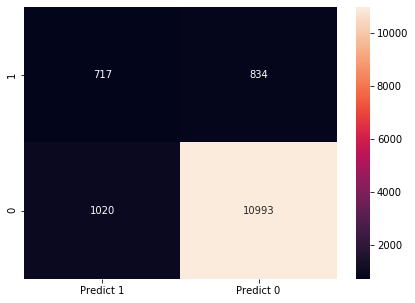

In [116]:
pred11 = GBC2.predict(xtest_sm_sc)

cm3=metrics.confusion_matrix(ytest_sm, pred11, labels=[1, 0])

df_gbc2 = pd.DataFrame(cm3, index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (7,5))
hm3 = sns.heatmap(df_gbc2, annot=True, fmt='g')
bottom, top = hm3.get_ylim()
hm3.set_ylim (bottom +0.5, top - 0.5)

**True Positive (TP):** The model correctly predicted that 717 people will subscribe to Term Deposit. 

**True Negative (TN):** The model correctly predicted that 10993 people will not subscribe to Term Deposit.

**False Positive (FP):** The model incorrectly predicted that 1020 people will subscribe to Term Deposit, but they did not subscribe to Term Deposit. **("Type I error")**

**False Negative (FN):** The model incorrectly predicted that 834 people will not subscribe to Term Deposit, but they have subscribed to Term Deposit. **("Type II error")**

In [120]:
# StratifiedKfold is used to maintain the original data ratio in each folds. 
# Below code will split the data in 50 folds, and run the model 20 times. 

kfold = StratifiedKFold(n_splits=50)
cv_gc = cross_val_score(GBC2, x_sc, y2, cv=kfold)
print("Cross Validation Score of Gradient Boosting Classifier : ", round(cv_gc.mean() * 100,2))

Cross Validation Score of Gradient Boosting Classifier :  82.32


**Gradient Boosting Classifier has been able to predict 82% with different combinations of training and test set of the dataset.**

In [170]:
cv_gc1 = cv_gc.mean()
f1_gc = metrics.f1_score(ytest_sm, pred11, average='micro')
tn_gc, fp_gc, fn_gc, tp_gc = metrics.confusion_matrix(ytest_sm, pred11).ravel()

In [119]:
print("Classification Report For Gradient Boosting classifier")
print("")
CR_GC = metrics.classification_report(ytest_sm, pred11, labels = [1,0])
print(CR_GC)

Classification Report For Gradient Boosting classifier

              precision    recall  f1-score   support

           1       0.41      0.46      0.44      1551
           0       0.93      0.92      0.92     12013

    accuracy                           0.86     13564
   macro avg       0.67      0.69      0.68     13564
weighted avg       0.87      0.86      0.87     13564



**Precision** [ TP/(TP + FP) => 717/(717+1020) => 0.41 ] => **Out of total positives predicted, 41% were predicted correctly.**  

**Recall** [ TP/(TP + FN) => 717/(717+834) => 0.46 ]   => **Out of actual positives, 46% were predicted correctly.**

**Accuracy** [ (TP +TN)/(TP + TN + FP + FN) => (717 + 10993)/(717 + 10993 + 834 + 1020) => 0.86 ] => **Model has accuracy of 86%.**

**F1 Score** [2 * (precision * recall) / (precision + recall) => 2 * (0.41 * 0.46)/(0.41 + 0.46) => 0.44] => **Weighted average of precision and recall is 0.44**

### 11. XGBoost Classifier

In [121]:
XGB1 = XGBClassifier(learning_rate =0.01, n_jobs = -1)
XGB1.fit(xtrain_sm_sc,ytrain_sm)
XGB1_TR = XGB1.score(xtrain_sm_sc,ytrain_sm)
XGB1_TS = XGB1.score(xtest_sm_sc,ytest_sm)
print("XGBoost Classifier Training score with default parameters  : ", round(XGB1_TR * 100, 2))
print("XGBoost Classifier Test score with default parameters      : ", round(XGB1_TS * 100, 2))

XGBoost Classifier Training score with default parameters  :  77.06
XGBoost Classifier Test score with default parameters      :  70.78


In [212]:
XGB1

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

#### Tuning of XGB Classifier

In [123]:
hyperparm9 = {'n_estimators':[25, 50, 75], 'max_depth':np.arange(4, 8), 'gamma': np.arange(2,5)}


XGB1_parms, XGB1_score = parm_tune(XGB1, hyperparm9, 10, xtrain_sm_sc, ytrain_sm)
print("Best Parameters Identified: \n", XGB1_parms)

Best Parameters Identified: 
 {'n_estimators': 50, 'max_depth': 7, 'gamma': 4}


* n_estimators denotes the number of underlying decistion trees to be built. Default value is 10 (i.e. 10 trees would be built)


* gamma denotes Minimum loss reduction required to make a further partition on a leaf node of the tree. Default value is 0.


* max_depth denotes the depth of tree. Default is braching would happen until last leaf/last value from input.

In [124]:
XGB2 = XGBClassifier(n_estimators = 50, max_depth = 7, gamma = 4, learning_rate =0.01, n_jobs = -1)
XGB2.fit(xtrain_sm_sc,ytrain_sm)
XGB2_TR = XGB2.score(xtrain_sm_sc,ytrain_sm)
XGB2_TS = XGB2.score(xtest_sm_sc,ytest_sm)
print("XGBoost Classifier Training score with default parameters  : ", round(XGB2_TR * 100, 2))
print("XGBoost Classifier Test score with default parameters      : ", round(XGB2_TS * 100, 2))

XGBoost Classifier Training score with default parameters  :  86.57
XGBoost Classifier Test score with default parameters      :  83.6


**With default parameters, XGB classifier score is 70.78, and the score is 83.6 with best parameters. There is a significant increase in model score with hyperparameters chosen by RandomizedSearchCV**

(2.0, 0.0)

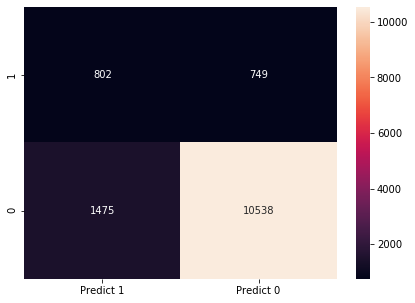

In [132]:
pred12 = XGB2.predict(xtest_sm_sc)

cm3=metrics.confusion_matrix(ytest_sm, pred12, labels=[1, 0])
df_xgb2 = pd.DataFrame(cm3, index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (7,5))
hm3 = sns.heatmap(df_xgb2, annot=True, fmt='g')
bottom, top = hm3.get_ylim()
hm3.set_ylim (bottom +0.5, top - 0.5)

**True Positive (TP):** The model correctly predicted that 802 people will subscribe to Term Deposit. 

**True Negative (TN):** The model correctly predicted that 10538 people will not subscribe to Term Deposit.

**False Positive (FP):** The model incorrectly predicted that 1475 people will subscribe to Term Deposit, but they did not subscribe to Term Deposit. **("Type I error")**

**False Negative (FN):** The model incorrectly predicted that 749 people will not subscribe to Term Deposit, but they have subscribed to Term Deposit. **("Type II error")**

In [129]:
# StratifiedKfold is used to maintain the original data ratio in each folds. 
# Below code will split the data in 50 folds, and run the model 20 times. 

kfold = StratifiedKFold(n_splits=50)
cv_xgb = cross_val_score(XGB2, x_sc, y2, cv=kfold)
print("Cross Validation Score of XGB Classifier : ", round(cv_xgb.mean() * 100,2))

Cross Validation Score of XGB Classifier :  85.03


**XGB Classifier has been able to predict 85% with different combinations of training and test set of the dataset.**

In [171]:
cv_xgb1 = cv_xgb.mean()
f1_xgb = metrics.f1_score(ytest_sm, pred12, average='micro')
tn_xgb, fp_xgb, fn_xgb, tp_xgb = metrics.confusion_matrix(ytest_sm, pred12).ravel()

In [128]:
print("Classification Report For XGB classifier")
print("")
CR_XGB = metrics.classification_report(ytest_sm, pred12, labels = [1,0])
print(CR_XGB)

Classification Report For XGB classifier

              precision    recall  f1-score   support

           1       0.35      0.52      0.42      1551
           0       0.93      0.88      0.90     12013

    accuracy                           0.84     13564
   macro avg       0.64      0.70      0.66     13564
weighted avg       0.87      0.84      0.85     13564



**Precision** [ TP/(TP + FP) => 802/(802+1475) => 0.35 ] => **Out of total positives predicted, 35% were predicted correctly.**  

**Recall** [ TP/(TP + FN) => 802/(802+749) => 0.52 ]   => **Out of actual positives, 52% were predicted correctly.**

**Accuracy** [ (TP +TN)/(TP + TN + FP + FN) => (802 + 10538)/(802 + 10538 + 749 + 1475) => 0.84 ] => **Model has accuracy of 84%.**

**F1 Score** [2 * (precision * recall) / (precision + recall) => 2 * (0.35 * 0.52)/(0.35 + 0.52) => 0.42] => **Weighted average of precision and recall is 0.42**

## Models comparison

### ROC - AOC Curve to Compare Model outcomes

In [200]:
# fpr, tpr and thresholds are caluclated for the all the models

lr_probs = log_reg.predict_proba(xtest_sm_sc)
fpr1, tpr1, thres1 = roc_curve(ytest_sm,lr_probs[:,1])
roc_auc1 = auc(fpr1,tpr1)
print("Logistic Regression - Area under the ROC curve : ", roc_auc1)

knn_probs = KNN3.predict_proba(xtest_sm_sc)
fpr2, tpr2, thres2 = roc_curve(ytest_sm,knn_probs[:,1])
roc_auc2 = auc(fpr2,tpr2)
print("KNN - Area under the ROC curve                 : ", roc_auc2)

nb_probs = GNM3.predict_proba(xtest_sm_sc)
fpr3, tpr3, thres3 = roc_curve(ytest_sm,nb_probs[:,1])
roc_auc3 = auc(fpr3,tpr3)
print("Naive Bayes - Area under the ROC curve         : ", roc_auc3)

dt_probs = DT4.predict_proba(xtest_sm_sc)
fpr4, tpr4, thres4 = roc_curve(ytest_sm,dt_probs[:,1])
roc_auc4 = auc(fpr4,tpr4)
print("Decision Tree - Area under the ROC curve       : ", roc_auc4)

rfcl_probs = RFCL2.predict_proba(xtest_sm_sc)
fpr5, tpr5, thres5 = roc_curve(ytest_sm,rfcl_probs[:,1])
roc_auc5 = auc(fpr5,tpr5)
print("Random Forest - Area under the ROC curve       : ", roc_auc5)

bc_probs = BC3.predict_proba(xtest_sm_sc)
fpr6, tpr6, thres6 = roc_curve(ytest_sm,bc_probs[:,1])
roc_auc6 = auc(fpr6,tpr6)
print("Bagging Classifier - Area under the ROC curve  : ", roc_auc6)

bcgnb_probs = BC3_GNB.predict_proba(xtest_sm_sc)
fpr7, tpr7, thres7 = roc_curve(ytest_sm,bcgnb_probs[:,1])
roc_auc7 = auc(fpr7,tpr7)
print("Bagging Classifier (With GNB) - Area under the ROC curve  : ", roc_auc7)

ac_probs = AC3.predict_proba(xtest_sm_sc)
fpr8, tpr8, thres8 = roc_curve(ytest_sm,ac_probs[:,1])
roc_auc8 = auc(fpr8,tpr8)
print("AdaBoost Classifier - Area under the ROC curve            : ", roc_auc8)
  
acgnb_probs = AC2_GNB.predict_proba(xtest_sm_sc)
fpr9, tpr9, thres9 = roc_curve(ytest_sm,acgnb_probs[:,1])
roc_auc9 = auc(fpr9,tpr9)
print("AdaBoost Classifier (With GNB) - Area under the ROC curve : ", roc_auc9)

gbc_probs = GBC2.predict_proba(xtest_sm_sc)
fpr10, tpr10, thres10 = roc_curve(ytest_sm,gbc_probs[:,1])
roc_auc10 = auc(fpr10,tpr10)
print("GradientBoost Classifier - Area under the ROC curve       : ", roc_auc10)

xgb_probs = XGB2.predict_proba(xtest_sm_sc)
fpr11, tpr11, thres11 = roc_curve(ytest_sm,xgb_probs[:,1])
roc_auc11 = auc(fpr11,tpr11)
print("XGBoost Classifier - Area under the ROC curve             : ", roc_auc11)

Logistic Regression - Area under the ROC curve :  0.7158944455348528
KNN - Area under the ROC curve                 :  0.7226516588546374
Naive Bayes - Area under the ROC curve         :  0.6898050967029432
Decision Tree - Area under the ROC curve       :  0.7062566756205385
Random Forest - Area under the ROC curve       :  0.7778932322565018
Bagging Classifier - Area under the ROC curve  :  0.7860892747664349
Bagging Classifier (With GNB) - Area under the ROC curve  :  0.7151675841393186
AdaBoost Classifier - Area under the ROC curve            :  0.7375289975726382
AdaBoost Classifier (With GNB) - Area under the ROC curve :  0.7127663063059292
GradientBoost Classifier - Area under the ROC curve       :  0.779866406278219
XGBoost Classifier - Area under the ROC curve             :  0.7542312720213966


<Figure size 432x288 with 0 Axes>

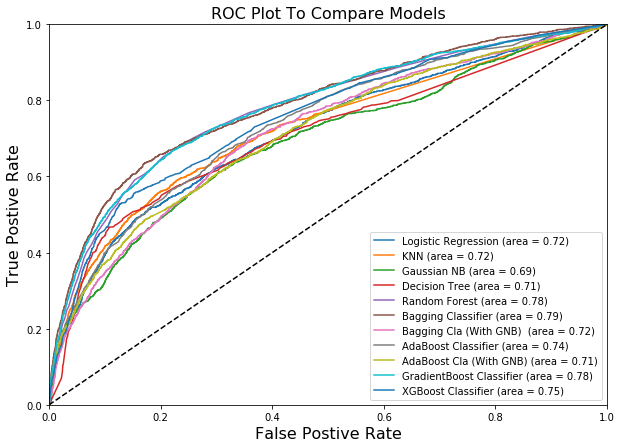

In [205]:
# Plot the ROC Plot
plt.clf()
plt.figure(figsize=(10,7))
plt.plot(fpr1,tpr1, label='Logistic Regression (area = %0.2f)' % roc_auc1)
plt.plot(fpr2,tpr2, label='KNN (area = %0.2f)' % roc_auc2)
plt.plot(fpr3,tpr3, label='Gaussian NB (area = %0.2f)' % roc_auc3)
plt.plot(fpr4,tpr4, label='Decision Tree (area = %0.2f)' % roc_auc4)
plt.plot(fpr5,tpr5, label='Random Forest (area = %0.2f)' % roc_auc5)
plt.plot(fpr6,tpr6, label='Bagging Classifier (area = %0.2f)' % roc_auc6)
plt.plot(fpr7,tpr7, label='Bagging Cla (With GNB)  (area = %0.2f)' % roc_auc7)
plt.plot(fpr8,tpr8, label='AdaBoost Classifier (area = %0.2f)' % roc_auc8)
plt.plot(fpr9,tpr9, label='AdaBoost Cla (With GNB) (area = %0.2f)' % roc_auc9)
plt.plot(fpr10,tpr10, label='GradientBoost Classifier (area = %0.2f)' % roc_auc10)
plt.plot(fpr11,tpr11, label='XGBoost Classifier (area = %0.2f)' % roc_auc11)
#plt.plot(fpr1,tpr1)
plt.plot([0,1],[0,1],'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Postive Rate",fontsize=16)
plt.ylabel("True Postive Rate",fontsize=16)
plt.title("ROC Plot To Compare Models",fontsize=16)
plt.legend(loc="lower right")
plt.show()

**Observations -**

* **Bagging Classifier has the highest ROC value.**


* **Random Forest and GradientBoost Classifier's ROC values are very close to Bagging Classifier.**


* **ROC value suggests that Bagging Classifier, Random Forest and GradientBoost Classifier models perform well when compared to other models.**  

### Bar Chart to Compare Model's Training Score, Test Score, Cross Validation Score and F1 Score

In [173]:
# Loading the values in a dataframe

mod_dict = {'Model': ['Log_Reg', 'KNN', 'Gaussian NB', 'Decision Tree', 'Random Forest', 'Bagging', 'Bagging GNB', 'AdaBoost', 
                   'AdaBoost GNB', 'Gradient Boost','XGBoost'], 
     'Train_Score':[LR3_TR, KNN_TR, GNM_TR, DT4_TR, RFCL2_TR, BC3_TR, BC3_GNB_TR, AC3_TR, AC2_GNB_TR, GBC2_TR,XGB2_TR], 
     'Test_Score':[LR3_TS, KNN_TS, GNM_TS, DT4_TS, RFCL2_TS, BC3_TS, BC3_GNB_TS, AC3_TS, AC2_GNB_TS, GBC2_TS, XGB2_TS],
     'Cross_Val_Score': [cv_log, cv_knn1, cv_gnm1, cv_dt1, cv_rfcl1, cv_bc1, cv_bcgn, cv_ac1, cv_acgn, cv_gc1, cv_xgb1], 
     'F1_score':[f1_log, f1_knn, f1_gnm, f1_dt, f1_rfcl, f1_bc, f1_bcgn, f1_ac, f1_acgn, f1_gc, f1_xgb]}
     
df_mod = pd.DataFrame(mod_dict)

df_mod = df_mod.set_index('Model')
df_mod

,Train_Score,Test_Score,Cross_Val_Score,F1_score
Model,,,,
Log_Reg,0.818911,0.810233,0.884121,0.810233
KNN,1.000000,0.841418,0.814460,0.841418
Gaussian NB,0.730033,0.585889,0.778168,0.585889
Decision Tree,0.910853,0.850560,0.811585,0.850560
Random Forest,0.999713,0.874226,0.757062,0.874226
Bagging,0.991204,0.874816,0.864676,0.874816
Bagging GNB,0.717564,0.546889,0.874153,0.546889
AdaBoost,0.820596,0.761280,0.889387,0.761280
AdaBoost GNB,0.834462,0.777499,0.870204,0.777499


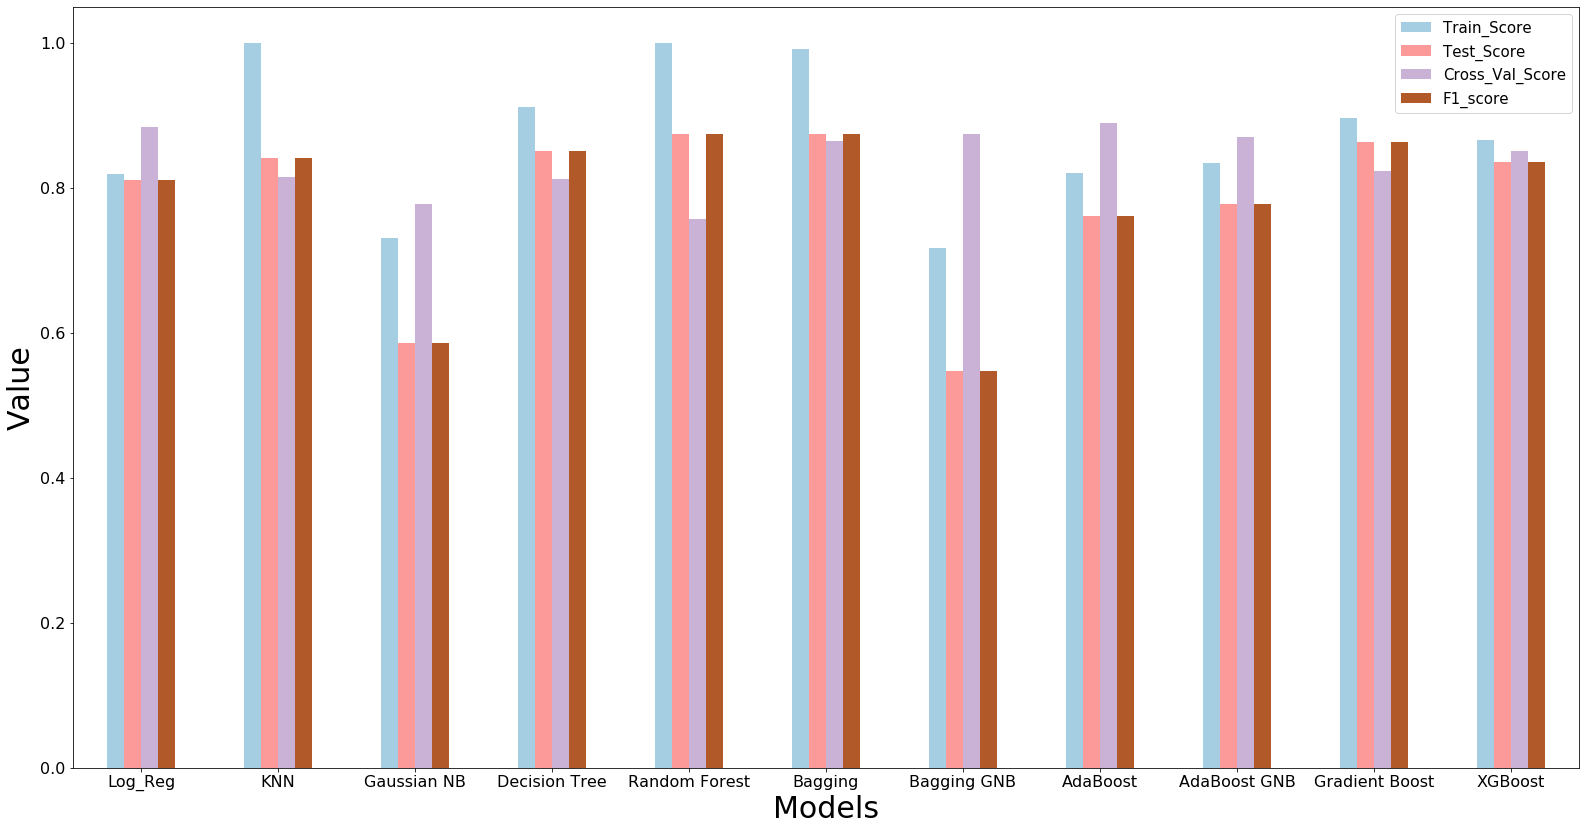

In [206]:
# Plot the bar chart

ax = df_mod.plot(kind='bar', rot=0, figsize = (27,14), fontsize = 16,colormap='Paired')
ax.legend(bbox_to_anchor=(1, 1), prop={'size': 15})
ax.set_ylabel("Value", fontsize=30)
ax.set_xlabel("Models", fontsize=30)
plt.show()

**Observations -**

* **Bagging Classifier has the highest F1 score, and Random Forest is very close to Bagging Classifier.** 


* **GradientBoost and Decision Tree models have Very good F1 scores as well.** 


* **Cross validation score of Bagging Classifier is highest among Random Forest, GradientBoost and Decision Tree models.**


* **Gaussian NB and Bagging (with GNB) models have the lowest F1 score.**


* **Remaining models(Log Reg, KNN, AdaBoost, AdaBoost (with GNB), XGBoost) have good F1 scores, but not as good as Bagging Classifier, Random Forest, GradientBoost and Decision Tree.** 

### Bar Chart to Compare Model's True Positives, False Positives, True Negatives, False Negatives

In [208]:
# Loading the values in a dataframe

mod_dict2 = {'Model': ['Log_Reg', 'KNN', 'Gaussian NB', 'Decision Tree', 'Random Forest', 'Bagging', 'Bagging GNB', 'AdaBoost', 
                   'AdaBoost GNB', 'Gradient Boost','XGBoost'], 
     'True_Positive':[tp_log, tp_knn, tp_gnm, tp_dt, tp_rfcl, tp_bc, tp_bcgn, tp_ac, tp_acgn, tp_gc, tp_xgb], 
     'False_Negative':[fn_log, fn_knn, fn_gnm, fn_dt, fn_rfcl, fn_bc, fn_bcgn, fn_ac, fn_acgn, fn_gc, fn_xgb],
     'True_Negative': [tn_log, tn_knn, tn_gnm, tn_dt, tn_rfcl, tn_bc, tn_bcgn, tn_ac, tn_acgn, tn_gc, tn_xgb], 
     'False_Positive':[fp_log, fp_knn, fp_gnm, fp_dt, fp_rfcl, fp_bc, fp_bcgn, fp_ac, fp_acgn, fp_gc, fp_xgb]}
     
df_mod2 = pd.DataFrame(mod_dict2)

df_mod2 = df_mod2.set_index('Model')
df_mod2

,True_Positive,False_Negative,True_Negative,False_Positive
Model,,,,
Log_Reg,730,821,10260,1753
KNN,652,899,10761,1252
Gaussian NB,1082,469,6865,5148
Decision Tree,682,869,10855,1158
Random Forest,600,951,11258,755
Bagging,675,876,11191,822
Bagging GNB,1201,350,6217,5796
AdaBoost,860,691,9466,2547
AdaBoost GNB,771,780,9775,2238


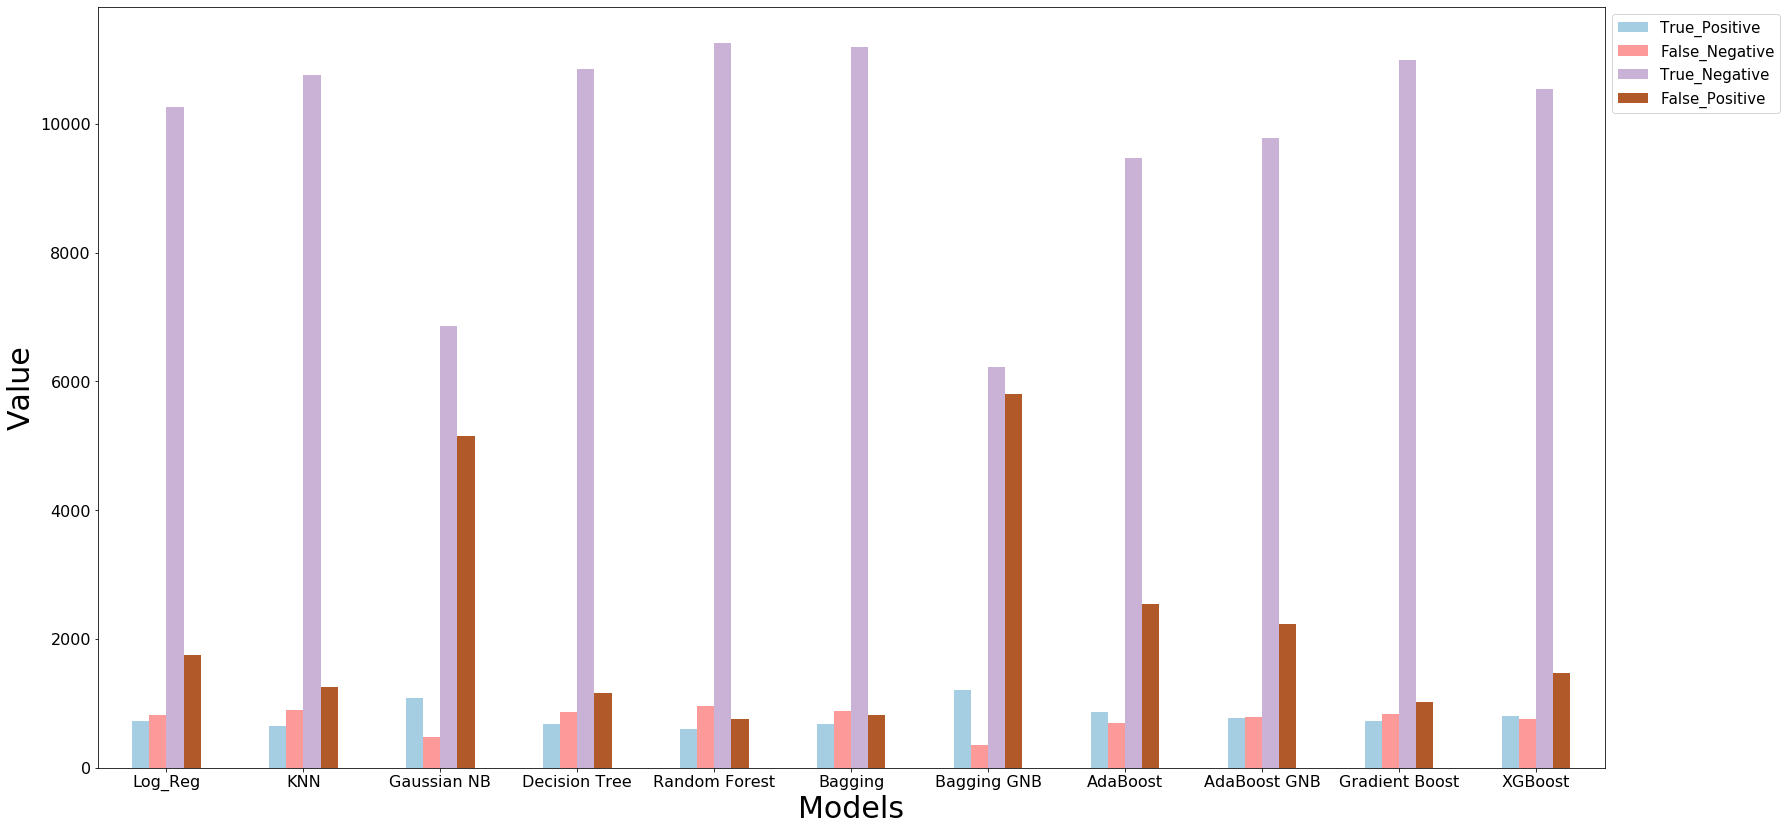

In [209]:
# Plot the bar chart

ax2 = df_mod2.plot(kind='bar', rot=0, figsize = (27,14), fontsize = 16,colormap='Paired')
ax2.legend(bbox_to_anchor=(1, 1), prop={'size': 15})
ax2.set_ylabel("Value", fontsize=30)
ax2.set_xlabel("Models", fontsize=30)
plt.show()

**Observations -**


* **Bagging Classifier GNB has the highest True Positives and the lowest False Negatives (Type II error). True Positive value is almost double when compared to remaining models. Remaining models False negative value is almost 2X than Bagging Classifier GNB.**  


* **Bagging Classifier GNB has the lowest True Negatives and the highest False Positives (Type I error). This means the model is not able to predict '0' (i.e. who do not subscribe to Term Deposit) efficiently.**

## Conclusion

The assignment is to build a model for Portugese Bank to predict whether a customer will subscribe to Term Deposit. 

**Points to consider -** 

1) Multiple models were built in this assignment - Logistic Regression, KNN, Gaussian NB, Decistion Tree, Random Forest, Bagging classifier, Bagging classifier (with GNB), AdaBoost classifier, AdaBoost classifier (with GNB), Gradient Boost classifier and XGBoost classifier.

2) Initially, Support Vector Machine model was also built, it took more time to fit and predict since the dataset is large. Considering the cost factor, SVM was not considered further.

3) Except Gaussian Naive Bayes and Bagging Classifer (with GNB), all the models have accuracy range from .76 to .86

4) Bagging Classifier, Random Forest, GradientBoost and Decision Tree models have Very good F1 scores.

5) Bagging Classifier, Random Forest and GradientBoost Classifier's ROC values are very good and close to each other. 

6) Bagging Classifier (with underlying GNB) has the highest True Positives and the lowest False Negatives (Type II error).

7) Cross validation score of Bagging Classifier is highest among Random Forest, GradientBoost and Decision Tree models.

**Final Words -** 

Bagging Classifier, Random Forest, GradientBoost and Decision Tree models have very good Accuracy and F1 score, hence remaining models are not considered. All these four models are almost equally good in terms of Accuracy and F1 score. 

Among these four models, Bagging Classifier has the highest Cross Validation Score, which means Bagging Classifier shows very good consistency with multiple training and test folds of dataset. This shows Bagging Classifier will perform better with new data. 

**Bagging Classifier outperforms all the other models in predicting whether the client will subscribe (yes/no) a term deposit.** 

Interestingly, "Bagging Classifier (with underlying GNB)" model has the highest True Positives and the lowest False Negatives (Type II error). Out of 1551 values, the model has predicted 1201 values correctly, whereas other models has predicted in the range of 600 to 800. At the sametime, this model has the highest False Positives (Type I error has been increased since there is a reduction in Type II error). I would have discussed this scenario with business - the bank is making phone calls to customers for their marketing campaign. High number of True Positive indicates more profit to the bank. However, high number of False positives indicate bank needs to make lots of additional phone calls. In addition, this model has impressive cross validation score. If bank is fine with additional phone call's, then I suggest **Bagging Classifier (with underlying GNB)** model.

**Therefore,**


**"Bagging Classifier" model wins if bank is looking for a balanced model.** 


**"Bagging Classifier (with underlying GNB)" model wins if bank is fine with lots of additional phone call's.**

=========================================================================================================================

**From data analysis, I could suggest the following for bank's future campaigns**


1) Around 35% of retired people and students have subscribed to term deposit, Bank should make more number of calls to Retired people and students.  


2) Bank should focus more on single marital status. Ratio of singles subscribing to Term deposit is higher than married and divorced people. 


3) Bank should focus more on people with education level tertiary. Ratio of people with tertiary education level subscribing to Term deposit is higher than Primary and Secondary education level.